# What do I want?

**UPDATE THIS**

- Match COSMOS galaxies to HSC objects 
- Remove non-matched HSC objects
- Create a classification based on COSMOS features
    - (z < 0.15) and ($10^8$ < M_stellar < $10^9$ M$_\odot$)
- Use that COSMOS classification to create an HSC training set
- Run Random Forest & Logistic Regression on that data set (pure HSC features! no COSMOS features)
- Create visual diagnostics

I'll test two basic classifiers: a RandomForest classifier and a Logistic Regression classifier. I'll try a very simplistic weak-learner: a straight i-band cut.

For my training data, I started by getting objects and labels from COSMOS. For input features, I then matched those COSMOS galaxies to their nearest HSC counterpart. I then used HSC i-band magnitude, along with HSC g-r, r-i, i-z, z-y colors.  Finally, I augment it with some HSC photo-z information (`FRANKEN-Z`).

In this notebook I'll look at the full decision curves for the classifiers, in hopes of better understanding my results.

# Code

In [1]:
# give access to importing dwarfz
import os, sys
dwarfz_package_dir = os.getcwd().split("dwarfz")[0]
if dwarfz_package_dir not in sys.path:
    sys.path.insert(0, dwarfz_package_dir)

import dwarfz
    
# back to regular import statements

%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
sns.set(context="poster", style="ticks", font_scale=1.4)

import numpy as np
import pandas as pd

from scipy.special import expit
import sklearn
import sklearn.metrics

import pathlib

In [2]:
%env HDF5_DISABLE_VERSION_CHECK=1

env: HDF5_DISABLE_VERSION_CHECK=1


In [3]:
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = 2*np.array((8,6))
mpl.rcParams['figure.facecolor'] = "white"

In [4]:
COSMOS_filename = pathlib.Path(dwarfz.data_dir_default) / "COSMOS_reference.sqlite"
COSMOS = dwarfz.datasets.COSMOS(COSMOS_filename)

In [5]:
HSC_filename = pathlib.Path(dwarfz.data_dir_default) / "HSC_COSMOS_median_forced.sqlite3"
HSC = dwarfz.datasets.HSC(HSC_filename)

In [6]:
matches_filename = pathlib.Path(dwarfz.data_dir_default) / "matches.sqlite3"
matches_df = dwarfz.matching.Matches.load_from_filename(matches_filename)

In [7]:
combined = matches_df[matches_df.match].copy()
combined["ra"]       = COSMOS.df.loc[combined.index].ra
combined["dec"]      = COSMOS.df.loc[combined.index].dec
combined["photo_z"]  = COSMOS.df.loc[combined.index].photo_z
combined["log_mass"] = COSMOS.df.loc[combined.index].mass_med

photometry_cols = [
    "gcmodel_flux","gcmodel_flux_err","gcmodel_flux_flags", "gcmodel_mag",
    "rcmodel_flux","rcmodel_flux_err","rcmodel_flux_flags", "rcmodel_mag",
    "icmodel_flux","icmodel_flux_err","icmodel_flux_flags", "icmodel_mag",
    "zcmodel_flux","zcmodel_flux_err","zcmodel_flux_flags", "zcmodel_mag",
    "ycmodel_flux","ycmodel_flux_err","ycmodel_flux_flags", "ycmodel_mag",
]

for col in photometry_cols:
    combined[col] = HSC.df.loc[combined.catalog_2_ids][col].values

## Turn magnitudes into colors

In [8]:
combined["g_minus_r"] = combined.gcmodel_mag - combined.rcmodel_mag
combined["r_minus_i"] = combined.rcmodel_mag - combined.icmodel_mag
combined["i_minus_z"] = combined.icmodel_mag - combined.zcmodel_mag
combined["z_minus_y"] = combined.zcmodel_mag - combined.ycmodel_mag

## Filter out bad data

In [9]:
mask =    np.isfinite(combined["g_minus_r"]) & np.isfinite(combined["r_minus_i"]) \
        & np.isfinite(combined["i_minus_z"]) & np.isfinite(combined["z_minus_y"]) \
        & np.isfinite(combined["icmodel_mag"]) \
        & (~combined.gcmodel_flux_flags) & (~combined.rcmodel_flux_flags) \
        & (~combined.icmodel_flux_flags) & (~combined.zcmodel_flux_flags) \
        & (~combined.ycmodel_flux_flags)

combined = combined[mask]

## Get FRANKENZ photo-z's


In [10]:
df_frankenz = pd.read_sql_table("photo_z",
                                "sqlite:///{}".format(
                                    pathlib.Path(dwarfz.data_dir_default)
                                                 / "HSC_matched_to_FRANKENZ.sqlite"),
                                index_col="object_id")

df_frankenz.head()

,FRANKENZ_ids,photoz_best,photoz_risk_best
object_id,,,
43158034708430853,43158034708462402,3.39,0.410430
43158034708430859,43158034708462728,2.68,0.186912
43158034708430861,43158034708462729,2.57,0.565077
43158034708430866,43158034708438547,1.59,0.466111
43158034708430870,43158034708438694,2.37,0.363387


In [11]:
combined = combined.join(df_frankenz[["photoz_best", "photoz_risk_best"]],
                         on="catalog_2_ids")

# Create classification labels

In [12]:
images_dir = pathlib.Path.home() / "dwarfz" / "galaxies_narrowband"


HSC_ids_target = {int(subdir.name)
                  for subdir in images_dir.glob("target/*")
                  if subdir.name[0] != "."}

HSC_ids_contaminant = {int(subdir.name)
                       for subdir in images_dir.glob("contaminant/*")
                       if subdir.name[0] != "."}

remove_ids = HSC_ids_target & HSC_ids_contaminant
HSC_ids_target -= remove_ids
HSC_ids_contaminant -= remove_ids

HSC_ids = HSC_ids_target | HSC_ids_contaminant

HSC_ids_target      = np.array(list(HSC_ids_target))
HSC_ids_contaminant = np.array(list(HSC_ids_contaminant))
HSC_ids             = np.array(list(HSC_ids))


print(len(HSC_ids_target))
print(len(HSC_ids_contaminant))
print(len(HSC_ids), len(HSC_ids_target) + len(HSC_ids_contaminant))

(~np.isin(HSC_ids, combined.catalog_2_ids)).sum()

HSC_ids = np.array(sorted(HSC_ids)) # enforce a deterministic ordering
print(HSC_ids.shape)

6278
18999
25277 25277
(25277,)


In [13]:
df = pd.DataFrame(data={
    "HSC_id" :HSC_ids,
    "target" : [HSC_id in HSC_ids_target for HSC_id in HSC_ids]
})

df = df.set_index("HSC_id")

df.head()

,target
HSC_id,
43158176442354210,False
43158176442354294,False
43158176442354356,False
43158176442354418,True
43158176442354561,False


In [14]:
cosmos_ids = set(pd.read_csv("target_galaxies-HSC_ids.csv", dtype=int).COSMOS_id)
cosmos_ids |= set(pd.read_csv("contaminant_galaxies-HSC_ids.csv", dtype=int).COSMOS_id)

combined = combined[combined.index.isin(cosmos_ids)]
combined = combined[combined.catalog_2_ids.isin(HSC_ids)]

# drop duplicatee HSC ids:
from collections import Counter
Counter(combined.catalog_2_ids)

for hsc_id, num_matches in Counter(combined.catalog_2_ids).most_common():
    if num_matches == 1:
        break
    combined = combined[~(combined.catalog_2_ids==hsc_id)]

mask_HSC_id_in_combined_filtered = np.isin(HSC_ids, combined.catalog_2_ids)
HSC_ids = HSC_ids[mask_HSC_id_in_combined_filtered].copy()

print(combined.shape)
combined.head()

(25274, 34)


,catalog_2_ids,sep,match,error,ra,dec,photo_z,log_mass,gcmodel_flux,gcmodel_flux_err,...,ycmodel_flux,ycmodel_flux_err,ycmodel_flux_flags,ycmodel_mag,g_minus_r,r_minus_i,i_minus_z,z_minus_y,photoz_best,photoz_risk_best
catalog_1_ids,,,,,,,,,,,,,,,,,,,,,
219965,43158447025312151,0.134196,True,False,150.405519,1.619062,0.0962,10.09820,1.187780e-27,2.307007e-30,...,4.620381e-27,9.980677e-30,False,17.238304,0.747993,0.381882,0.210592,0.134390,0.15,0.083668
220029,43158584464246406,0.206466,True,False,150.297964,1.615117,0.4297,8.23516,6.906496e-31,2.298444e-31,...,4.925158e-30,1.711062e-30,False,24.668949,0.925964,0.513643,0.369919,0.323380,0.81,0.109602
220142,43158859342153228,0.105345,True,False,149.829519,1.614976,0.4218,8.25359,8.714122e-31,2.017394e-31,...,4.227673e-30,1.529937e-30,False,24.834747,0.796980,0.466232,0.261429,0.190052,3.74,0.450802
220169,43158859342173270,0.278594,True,False,149.935872,1.615410,0.4393,7.39118,7.379574e-31,1.891935e-31,...,1.115907e-30,1.320634e-30,False,26.280930,0.357460,-0.398020,1.032396,-0.542845,0.69,0.674946
220274,43158447025298878,0.268834,True,False,150.404212,1.615583,0.4445,7.57285,5.672093e-31,2.500533e-31,...,2.688073e-30,1.785628e-30,False,25.326397,0.951115,-0.223770,0.441588,0.520313,2.84,0.407522


In [15]:
HSC_ids_target

array([43158593054212098, 43158593054212115, 43158605939114016, ...,
       43158464205193203, 43158593054212085, 43158593054212091])

In [16]:
combined["target"] = combined.catalog_2_ids.isin(set(HSC_ids_target)).values

combined["target"].mean()

0.24839756271266913

# Get vgg features

In [17]:
df_vgg = pd.read_hdf("vgg_features.h5")
df_vgg.vgg_features = df_vgg.vgg_features.apply(lambda arr: arr.flatten())

df_vgg = df_vgg.set_index("HSC_id").loc[HSC_ids]

print(df_vgg.shape)

df_vgg.head()

(25274, 1)


,vgg_features
HSC_id,
43158176442354210,"[0.4172121286392212, 0.4459249973297119, 0.324..."
43158176442354294,"[0.46113717555999756, 0.42641374468803406, 0.3..."
43158176442354356,"[0.6757300496101379, 0.4565524458885193, 0.480..."
43158176442354418,"[0.3692325949668884, 0.49743348360061646, 0.31..."
43158176442354561,"[0.5059124231338501, 0.4412170946598053, 0.430..."


# Build Classifiers

In [18]:
features = combined.loc[:,["g_minus_r", "r_minus_i", "i_minus_z", "z_minus_y",
                           "icmodel_mag",
                           "photoz_best",
                           "photoz_risk_best" # The risk of photoz_best being outside of the range z_true +- 0.15(1+z_true). It ranges from 0 (safe) to 1(risky)
                          ]]

target = combined.loc[:,["target"]]

In [19]:
features_combined = np.hstack([features.values, 
                              np.array([*df_vgg.vgg_features.values])])
print(features_combined.shape)

(25274, 2055)


In [20]:
target.mean()

target    0.248398
dtype: float64

## Partition training and testing sets

In [21]:
testing_fraction = .2
np.random.seed(1)
ids_shuffled = np.random.permutation(range(HSC_ids.size))

N_testing_indices = int(testing_fraction*ids_shuffled.size)
ids_testing  = ids_shuffled[:N_testing_indices]
ids_training = ids_shuffled[N_testing_indices:]


features_train = features_combined[ids_training]
features_test  = features_combined[ids_testing]


target_train = target.iloc[ids_training]
target_test  = target.iloc[ids_testing]


## Shared Plotting Parameters

In [22]:
color_RF = "g"
color_RF_with_vgg = "b"
color_RF_with_vgg_more = "orange"
color_CNN = "purple"
color_CNN_no_phot = "#069af3"
color_photoz = "#0165fc"
color_RF_no_photoz = sns.color_palette("hls", 8)[-1]

label_RF = "Random Forest"
label_RF_with_vgg = "RF (with VGG-19)"
label_RF_with_vgg_more = "RF (with VGG-19)\n$n_\mathrm{split\:features}=1024$"
label_CNN = "CNN"
label_CNN_no_phot = "CNN (no photometry)"
label_photoz = r"LR: only photo-$z$"
label_RF_no_photoz = r"RF: no photo-$z$"

linewidth=4

In [23]:
threshold_probs = expit(np.linspace(-9, 6, num=1000))
threshold_probs = np.array([0, *threshold_probs, 1])
threshold_probs

array([0.00000000e+00, 1.23394576e-04, 1.25261093e-04, ...,
       9.97490064e-01, 9.97527377e-01, 1.00000000e+00])

## Classifiers

In [24]:
from sklearn.ensemble import RandomForestClassifier

features_train_tmp = features_train[:,:7]
features_test_tmp = features_test[:,:7]

class_probs_filename_tmp = "class_probs.RF.h5"
recompute = False

if recompute or (not pathlib.Path(class_probs_filename_tmp).is_file()):

    classifier_RF = RandomForestClassifier(n_estimators=1000, n_jobs=4)
    classifier_RF = classifier_RF.fit(features_train_tmp, target_train.values.flatten())

    target_prob_RF = classifier_RF.predict_proba(features_test_tmp)[:,1]
    target_prob_RF = (target_prob_RF*classifier_RF.n_estimators + 1) / (2+classifier_RF.n_estimators)
    
    df_RF = pd.DataFrame(data={
        "HSC_id": HSC_ids[ids_testing],
        "target" : target_test.values.flatten(),
        "prob": target_prob_RF,
    })

    df_RF.to_hdf(class_probs_filename_tmp, "data")

else:
    df_RF = pd.read_hdf(class_probs_filename_tmp)
print("min prob: ", df_RF.prob.min())
print("max prob: ", df_RF.prob.max())


min prob:  0.000998003992015968
max prob:  0.999001996007984


In [27]:
from sklearn.ensemble import RandomForestClassifier

class_probs_filename_tmp = "class_probs.RF_with_vgg.h5"
recompute = False

if recompute or (not pathlib.Path(class_probs_filename_tmp).is_file()):

    classifier_RF_with_vgg = RandomForestClassifier(n_estimators=3000, n_jobs=8,
    #                                                 max_features=1024,
                                                   )
    classifier_RF_with_vgg = classifier_RF_with_vgg.fit(features_train, target_train.values.flatten())

    target_prob_RF_with_vgg = classifier_RF_with_vgg.predict_proba(features_test)[:,1]
    target_prob_RF_with_vgg = (target_prob_RF_with_vgg*classifier_RF_with_vgg.n_estimators + 1) / (2+classifier_RF_with_vgg.n_estimators)

    df_RF_with_vgg = pd.DataFrame(data={
        "HSC_id": HSC_ids[ids_testing],
        "target" : target_test.values.flatten(),
        "prob": target_prob_RF_with_vgg,
    })
    
    df_RF_with_vgg.to_hdf(class_probs_filename_tmp, "data")
    
else:
    df_RF_with_vgg = pd.read_hdf(class_probs_filename_tmp)
print("min prob: ", df_RF_with_vgg.prob.min())
print("max prob: ", df_RF_with_vgg.prob.max())

min prob:  0.049966688874083946
max prob:  0.6992005329780147


In [28]:
from sklearn.ensemble import RandomForestClassifier

class_probs_filename_tmp = "class_probs.RF_no_photoz.h5"
recompute = False

if recompute or (not pathlib.Path(class_probs_filename_tmp).is_file()):

    keys = [i for i, key in enumerate(features) if "photoz" not in key]

    classifier_RF_no_photoz = RandomForestClassifier(n_estimators=1000, n_jobs=4)
    classifier_RF_no_photoz = classifier_RF_no_photoz.fit(features_train[:, keys], 
                                                          target_train.values.flatten())

    target_prob_RF_no_photoz = classifier_RF_no_photoz.predict_proba(features_test[:, keys])[:,1]
    target_prob_RF_no_photoz = (target_prob_RF_no_photoz*classifier_RF_no_photoz.n_estimators + 1) / (2+classifier_RF_no_photoz.n_estimators)

    df_RF_no_photoz = pd.DataFrame(data={
        "HSC_id": HSC_ids[ids_testing],
        "target" : target_test.values.flatten(),
        "prob": target_prob_RF_no_photoz,
    })

    df_RF_no_photoz.to_hdf(class_probs_filename_tmp, "data")

else:
    df_RF_no_photoz = pd.read_hdf(class_probs_filename_tmp)
print("min prob: ", df_RF_no_photoz.prob.min())
print("max prob: ", df_RF_no_photoz.prob.max())


min prob:  0.000998003992015968
max prob:  0.999001996007984


In [29]:
from sklearn.linear_model import LogisticRegression

class_probs_filename_tmp = "class_probs.LR_photoz.h5"
recompute = False

if recompute or (not pathlib.Path(class_probs_filename_tmp).is_file()):

    keys = [i for i, key in enumerate(features) if "photoz" in key]


    classifier_photoz = LogisticRegression(class_weight=None)
    classifier_photoz = classifier_photoz.fit(features_train[:, keys], 
                                          np.array(target_train.values.flatten(), dtype=int))

    target_prob_photoz = classifier_photoz.predict_proba(features_test[:, keys])[:,1] 

    df_LR_photoz = pd.DataFrame(data={
        "HSC_id": HSC_ids[ids_testing],
        "target" : target_test.values.flatten(),
        "prob": target_prob_photoz,
    })

    df_LR_photoz.to_hdf(class_probs_filename_tmp, "data")

else:
    df_LR_photoz = pd.read_hdf(class_probs_filename_tmp)
print("min prob: ", df_LR_photoz.prob.min())
print("max prob: ", df_LR_photoz.prob.max())



min prob:  0.17830201491763284
max prob:  0.3228370903264788


In [30]:
from sklearn.ensemble import RandomForestClassifier

class_probs_filename_tmp = "class_probs.RF_with_vgg_more.h5"
recompute = False

if recompute or (not pathlib.Path(class_probs_filename_tmp).is_file()):

    classifier_RF_with_vgg_more = RandomForestClassifier(n_estimators=3000,
                                                         max_features=1024,
                                                         n_jobs=6,
                                                        )
    classifier_RF_with_vgg_more = classifier_RF_with_vgg_more.fit(features_train, target_train.values.flatten())

    target_prob_RF_with_vgg_more = classifier_RF_with_vgg_more.predict_proba(features_test)[:,1]
    target_prob_RF_with_vgg_more = (target_prob_RF_with_vgg_more*classifier_RF_with_vgg_more.n_estimators + 1) / (2+classifier_RF_with_vgg_more.n_estimators)
    
    df_RF_with_vgg_more = pd.DataFrame(data={
        "HSC_id": HSC_ids[ids_testing],
        "target" : target_test.values.flatten(),
        "prob": target_prob_RF_with_vgg_more,
    })

    df_RF_with_vgg_more.to_hdf(class_probs_filename_tmp, "data")

else:
    df_RF_with_vgg_more = pd.read_hdf(class_probs_filename_tmp)
print("min prob: ", df_RF_with_vgg_more.prob.min())
print("max prob: ", df_RF_with_vgg_more.prob.max())
    


min prob:  0.00033311125916055963
max prob:  0.9996668887408394


In [31]:
class_probs_filename = "class_probs.extracted_features.csv"
df_cnn = pd.read_csv(class_probs_filename)
df_cnn = df_cnn.set_index("HSC_id")
df_cnn = df_cnn.loc[HSC_ids]
print(df_cnn[df_cnn.testing].CNN_prob.min())
print(df_cnn[df_cnn.testing].CNN_prob.max())

df_cnn.head()

0.0020137585
0.99894875


,CNN_prob,testing,target
HSC_id,,,
43158176442354210,0.176649,True,False
43158176442354294,0.214090,False,False
43158176442354356,0.220580,True,False
43158176442354418,0.194056,False,True
43158176442354561,0.159319,False,False


In [32]:
class_probs_filename = "class_probs.with_photometry.csv"
df_cnn_with_photometry = pd.read_csv(class_probs_filename)
df_cnn_with_photometry = df_cnn_with_photometry.set_index("HSC_id")
df_cnn_with_photometry = df_cnn_with_photometry.loc[HSC_ids]
print(df_cnn_with_photometry[df_cnn_with_photometry.testing].CNN_prob.min())
print(df_cnn_with_photometry[df_cnn_with_photometry.testing].CNN_prob.max())

df_cnn_with_photometry.head()

0.00015297679
0.9999505


,CNN_prob,testing,target
HSC_id,,,
43158176442354210,0.285649,True,False
43158176442354294,0.118564,False,False
43158176442354356,0.303905,True,False
43158176442354418,0.328453,False,True
43158176442354561,0.017517,False,False


In [33]:
def get_TPR_FPR_recall_precision(predicted_probs_test, target=target_test, threshold_probs=threshold_probs):
    TPR = np.empty_like(threshold_probs)
    FPR = np.empty_like(threshold_probs)

    precision = np.empty_like(threshold_probs)
    recall    = np.empty_like(threshold_probs)
    for i, threshold in enumerate(threshold_probs):
        mask = target.values.reshape(-1)
        TPR[i] = (predicted_probs_test[ mask] > threshold).mean()
        FPR[i] = (predicted_probs_test[~mask] > threshold).mean()



        mask = target.values.reshape(-1)
        recall[i] = (predicted_probs_test[mask] > threshold).mean()

        mask = predicted_probs_test > threshold
        precision[i] = target[mask].mean()
        
    return TPR, FPR, recall, precision

In [34]:
(TPR_RF, 
 FPR_RF, 
 recall_RF, 
 precision_RF,) = get_TPR_FPR_recall_precision(df_RF.prob, 
                                               target=df_RF.target)

In [35]:
(TPR_RF_with_vgg, 
 FPR_RF_with_vgg, 
 recall_RF_with_vgg, 
 precision_RF_with_vgg,) = get_TPR_FPR_recall_precision(df_RF_with_vgg.prob, 
                                                        target=df_RF_with_vgg.target)

In [36]:
(TPR_RF_with_vgg_more, 
 FPR_RF_with_vgg_more, 
 recall_RF_with_vgg_more, 
 precision_RF_with_vgg_more,) = get_TPR_FPR_recall_precision(df_RF_with_vgg_more.prob, 
                                                        target=df_RF_with_vgg_more.target)

In [37]:
(TPR_CNN, 
 FPR_CNN, 
 recall_CNN,
 precision_CNN, ) = get_TPR_FPR_recall_precision(df_cnn_with_photometry[df_cnn_with_photometry.testing].CNN_prob,
                                                 target=df_cnn_with_photometry[df_cnn_with_photometry.testing].target)

In [38]:
(TPR_CNN_no_phot, 
 FPR_CNN_no_phot, 
 recall_CNN_no_phot,
 precision_CNN_no_phot, ) = get_TPR_FPR_recall_precision(df_cnn[df_cnn.testing].CNN_prob,
                                                         target=df_cnn[df_cnn.testing].target)

In [39]:
(TPR_LR_photoz, 
 FPR_LR_photoz, 
 recall_LR_photoz, 
 precision_LR_photoz,) = get_TPR_FPR_recall_precision(df_LR_photoz.prob, 
                                                      target=df_LR_photoz.target)


In [40]:
(TPR_RF_no_photoz, 
 FPR_RF_no_photoz, 
 recall_RF_no_photoz, 
 precision_RF_no_photoz,) = get_TPR_FPR_recall_precision(df_RF_no_photoz.prob, 
                                                         target=df_RF_no_photoz.target)


In [44]:
def plot_ROC_curves(with_RF=False, with_RF_with_vgg=False,  
                    with_RF_with_vgg_more=False, 
                    with_CNN=False, with_CNN_no_phot=False,
                    with_RF_no_photoz=False, with_photoz=False):

    if with_RF:
        plt.plot(FPR_RF, TPR_RF, 
                 label=label_RF + "\n(AUC={:.2f})".format(sklearn.metrics.roc_auc_score(df_RF.target, df_RF.prob)),
                 color=color_RF,
                 linewidth=linewidth,
                )
        
    if with_CNN:
        plt.plot(FPR_CNN, TPR_CNN, 
#                  label=label_CNN + "\n(AUC={:.2f})".format(sklearn.metrics.roc_auc_score(df_cnn[df_cnn.testing].target, df_cnn[df_cnn.testing].CNN_prob)),
                 label=label_CNN + "\n(AUC={:.2f})".format(sklearn.metrics.roc_auc_score(df_cnn_with_photometry[df_cnn_with_photometry.testing].target, df_cnn_with_photometry[df_cnn_with_photometry.testing].CNN_prob)),
                 color=color_CNN,
                 linewidth=linewidth,
                )

    if with_CNN_no_phot:
        plt.plot(FPR_CNN_no_phot, TPR_CNN_no_phot, 
#                  label=label_CNN + "\n(AUC={:.2f})".format(sklearn.metrics.roc_auc_score(df_cnn[df_cnn.testing].target, df_cnn[df_cnn.testing].CNN_prob)),
                 label=label_CNN_no_phot + "\n(AUC={:.2f})".format(sklearn.metrics.roc_auc_score(df_cnn[df_cnn.testing].target, df_cnn[df_cnn.testing].CNN_prob)),
                 color=color_CNN_no_phot,
                 linewidth=linewidth,
                )

        
        
    if with_RF_no_photoz:
        plt.plot(FPR_RF_no_photoz, TPR_RF_no_photoz, 
                 label=label_RF_no_photoz + "\n(AUC={:.2f})".format(sklearn.metrics.roc_auc_score(df_RF_no_photoz.target, df_RF_no_photoz.prob)),
                 color=color_RF_no_photoz,
                 linewidth=linewidth,
                )
        
    if with_RF_with_vgg_more:
        plt.plot(FPR_RF_with_vgg_more, TPR_RF_with_vgg_more, 
                 label=label_RF_with_vgg_more + "\n(AUC={:.2f})".format(sklearn.metrics.roc_auc_score(df_RF_with_vgg_more.target, df_RF_with_vgg_more.prob)),
                 color=color_RF_with_vgg_more,
                 linewidth=linewidth,
                )
        

    if with_RF_with_vgg:
        plt.plot(FPR_RF_with_vgg, TPR_RF_with_vgg, 
                 label=label_RF_with_vgg + "\n(AUC={:.2f})".format(sklearn.metrics.roc_auc_score(df_RF_with_vgg.target, df_RF_with_vgg.prob)),
                 color=color_RF_with_vgg,
                 linewidth=linewidth,
                )
        

        
    if with_photoz:
        plt.plot(FPR_LR_photoz, TPR_LR_photoz, 
                 label=label_photoz + "\n(AUC={:.2f})".format(sklearn.metrics.roc_auc_score(df_LR_photoz.target, df_LR_photoz.prob)),
                 color=color_photoz,
                 linewidth=linewidth,
                )



    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.plot([0,1], [0,1], linestyle="dashed", label="Random guessing", color="black",
             linewidth=linewidth)

    plt.legend(loc="best")


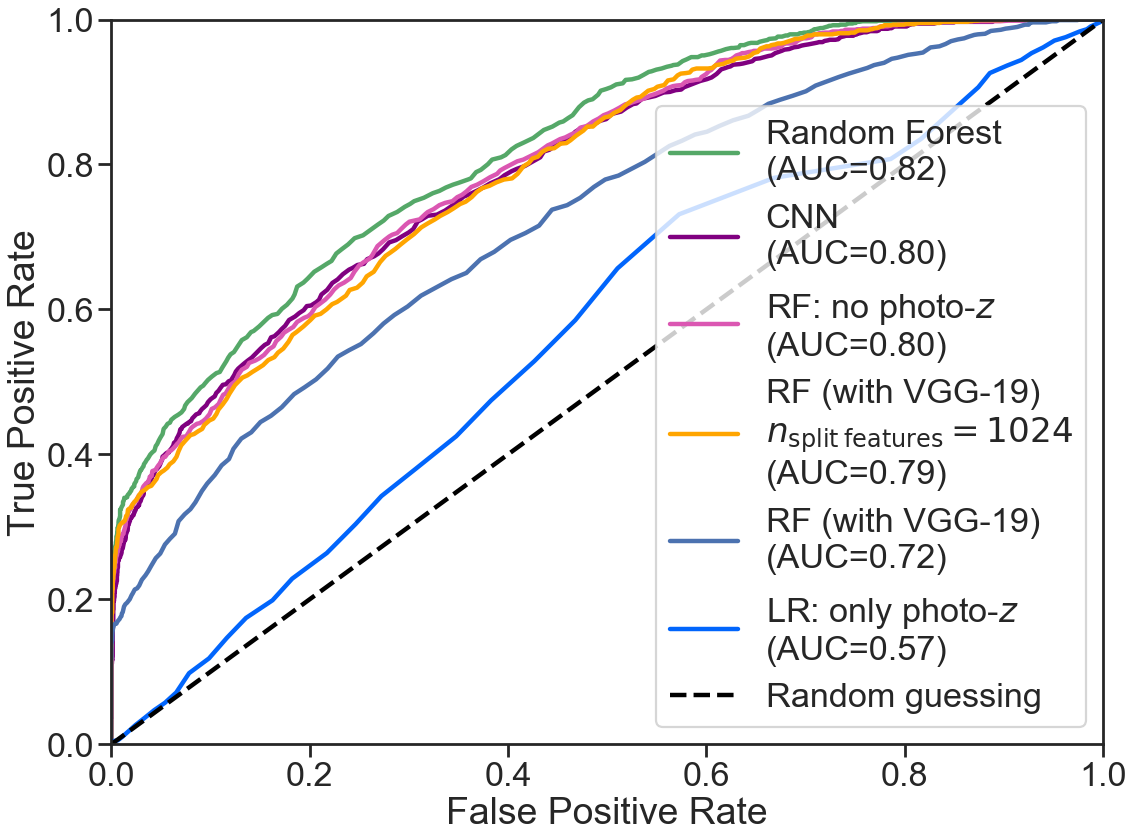

In [45]:
plot_ROC_curves(with_RF=True, with_RF_with_vgg=True,  
                    with_RF_with_vgg_more=True, 
                    with_CNN=True, with_CNN_no_phot=False,
                    with_RF_no_photoz=True, with_photoz=True)

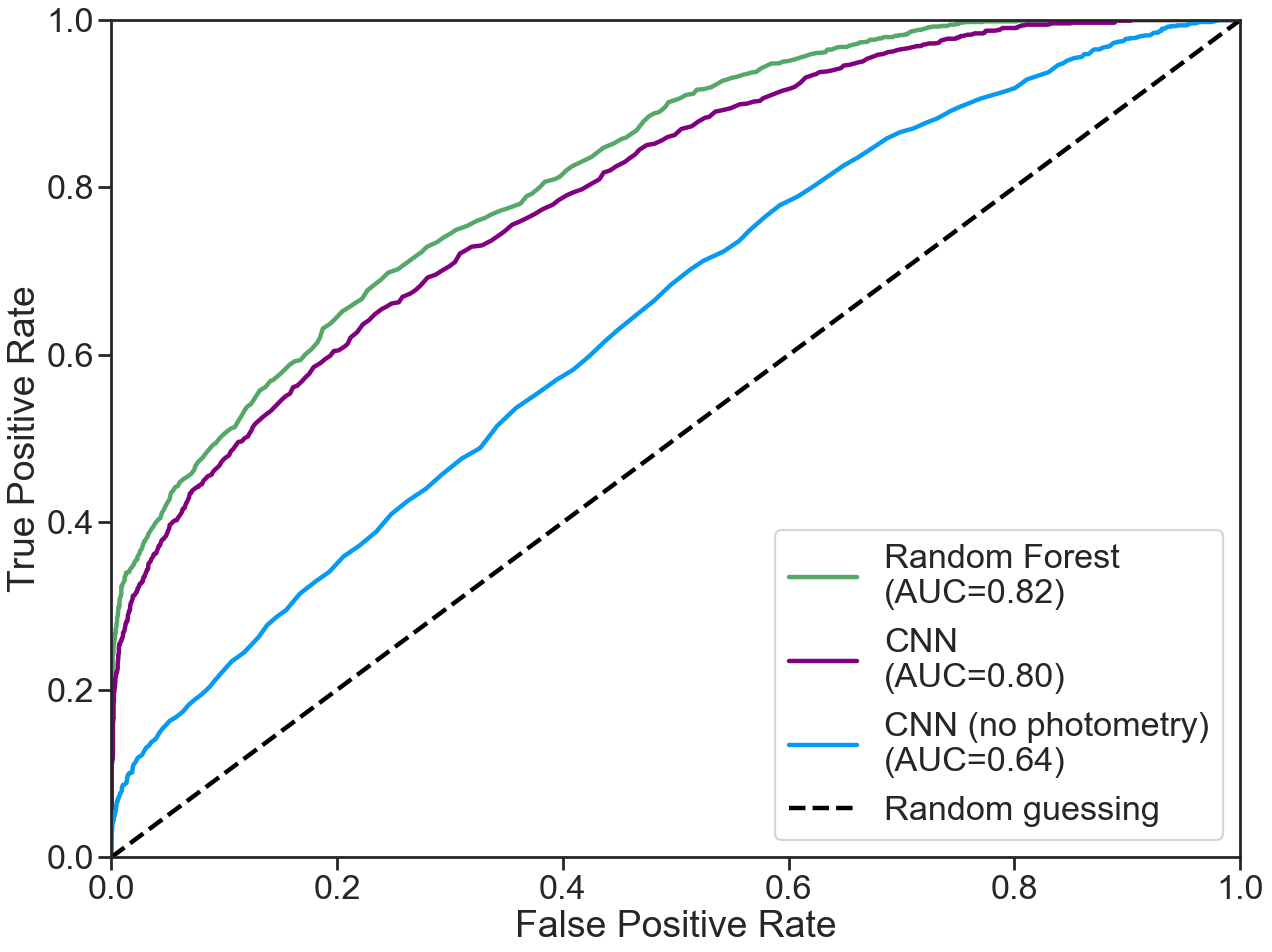

In [46]:
plot_ROC_curves(
    with_RF=True, 
    with_CNN=True, with_CNN_no_phot=True,   
)

plt.tight_layout()

plot_filename = pathlib.Path("plots_for_thesis") / "ROC-CNN_and_CNN_no_photometry"
plt.savefig(plot_filename.with_suffix(".png"))
plt.savefig(plot_filename.with_suffix(".pdf"))

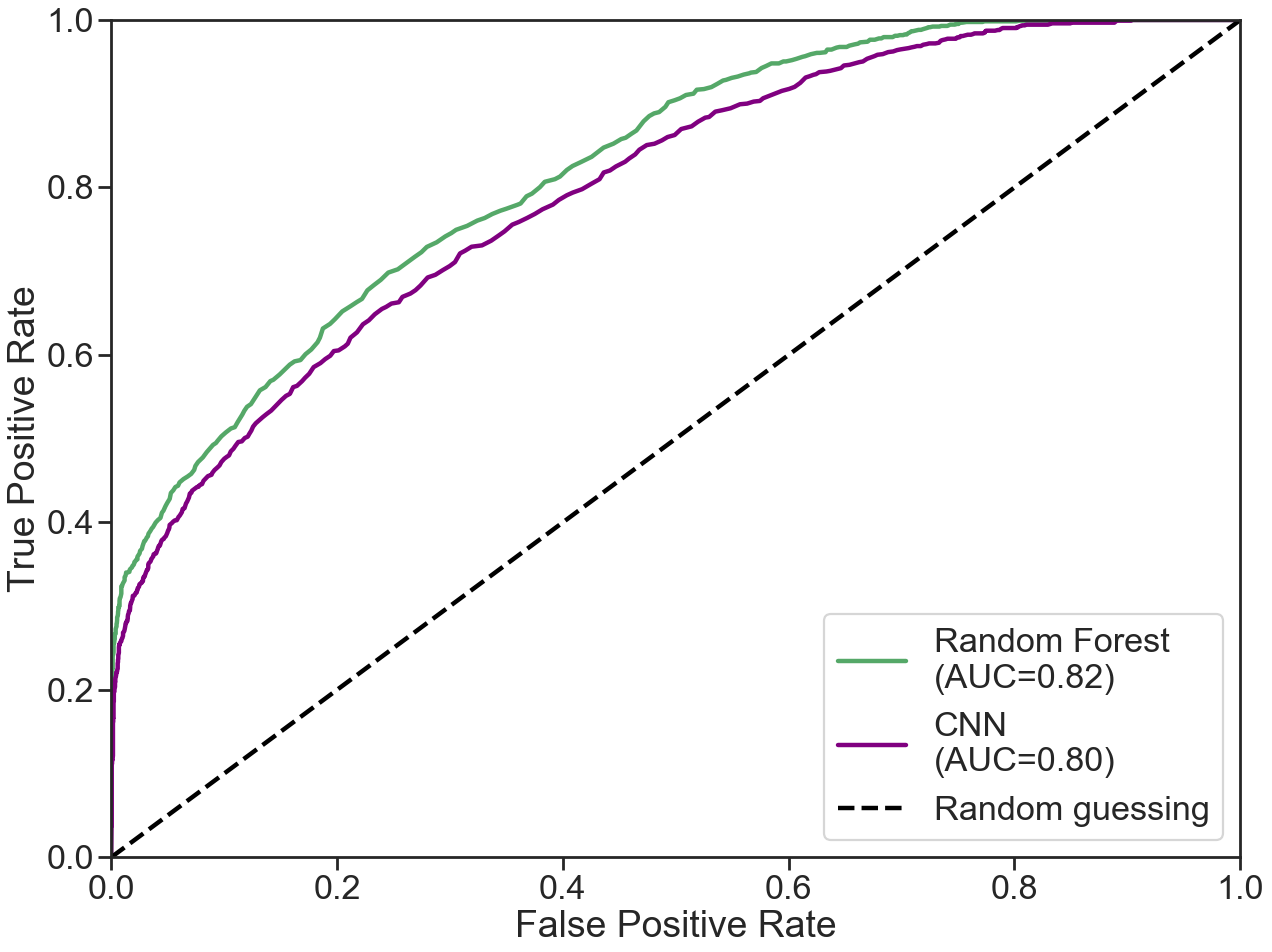

In [47]:
plot_ROC_curves(
    with_RF=True, 
    with_CNN=True, with_CNN_no_phot=False,   
)
    
plt.tight_layout()

plot_filename = pathlib.Path("plots_for_thesis") / "ROC-RF_and_CNN"
plt.savefig(plot_filename.with_suffix(".png"))
plt.savefig(plot_filename.with_suffix(".pdf"))

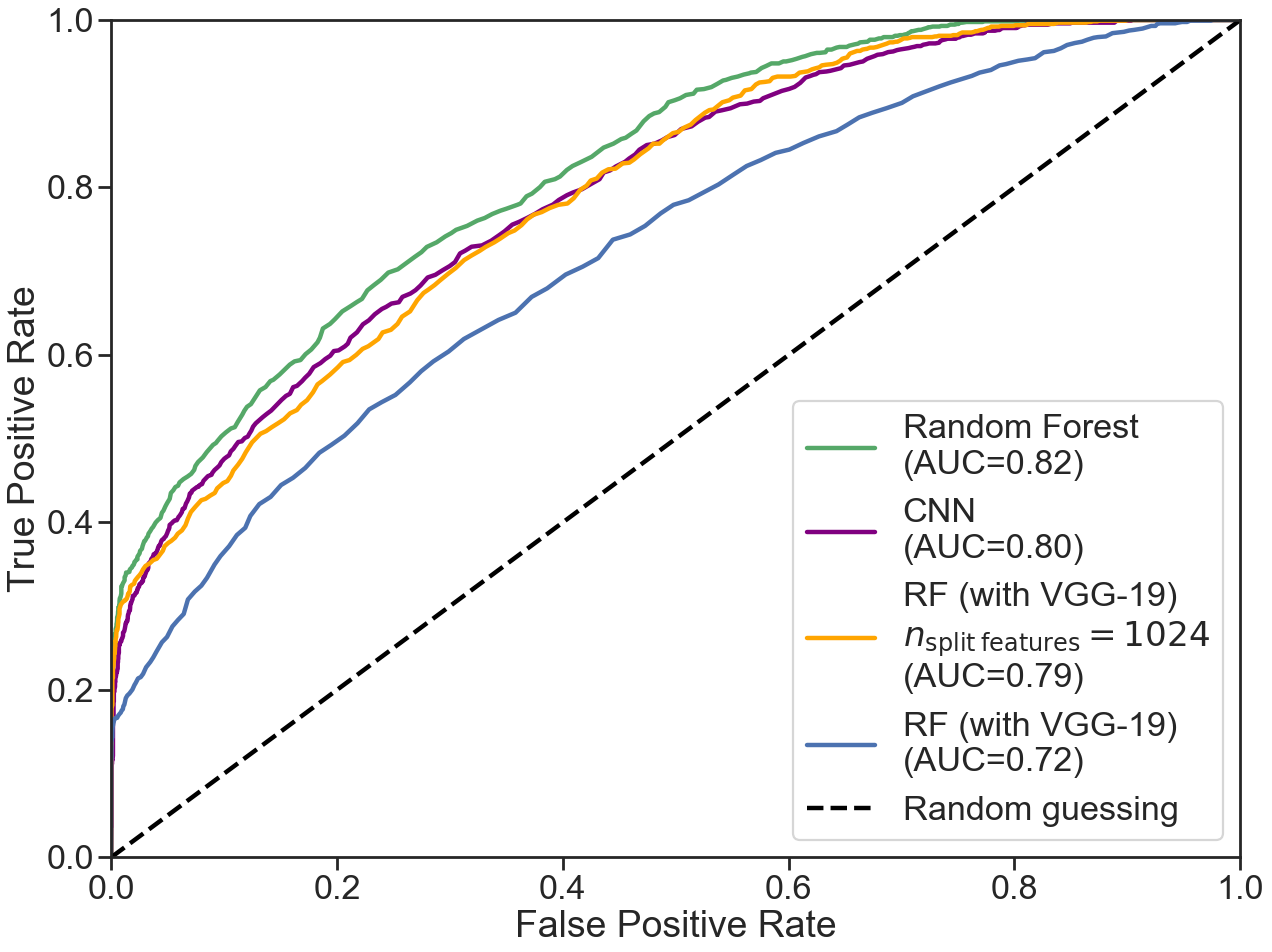

In [48]:
plot_ROC_curves(
    with_RF=True, with_RF_with_vgg=True,   
    with_RF_with_vgg_more=True,   
    with_CNN=True, 
)
    
plt.tight_layout()

plot_filename = pathlib.Path("plots_for_thesis") / "ROC-RF_and_RFvgg"
plt.savefig(plot_filename.with_suffix(".png"))
plt.savefig(plot_filename.with_suffix(".pdf"))

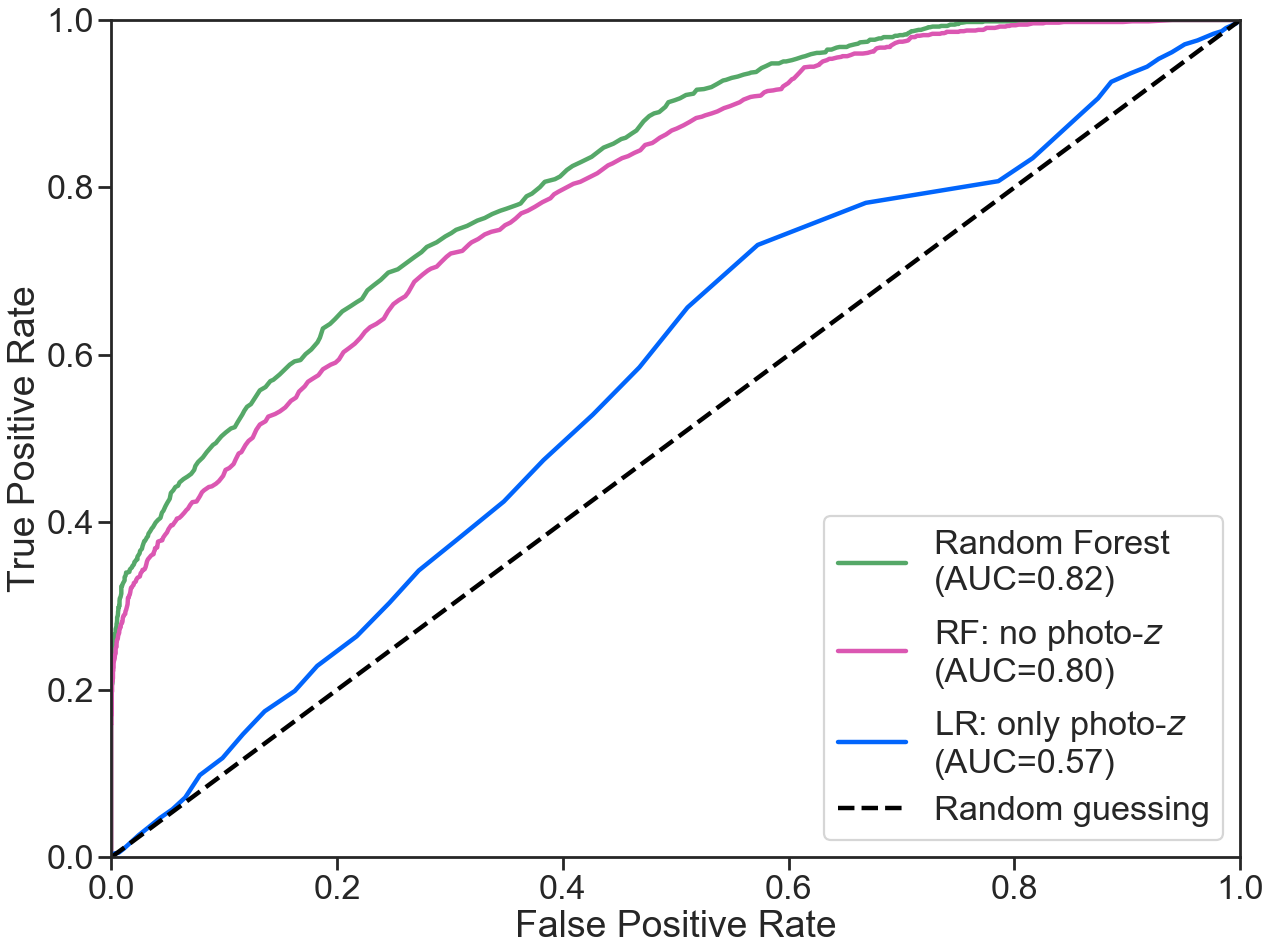

In [49]:
plot_ROC_curves(
    with_RF=True,
    with_RF_no_photoz=True,   
    with_photoz=True,
)

plt.tight_layout()

plot_filename = pathlib.Path("plots_for_thesis") / "ROC-RF_RFnoz_LRz"
plt.savefig(plot_filename.with_suffix(".png"))
plt.savefig(plot_filename.with_suffix(".pdf"))

In [52]:
def plot_PR_curves(with_RF=False, with_RF_with_vgg=False, 
                   with_RF_with_vgg_more=False, 
                   with_CNN=False, with_CNN_no_phot=False,
                   with_RF_no_photoz=False, with_photoz=False):

    if with_RF:
        plt.plot(recall_RF, precision_RF, 
                 label=label_RF + "\n(AUC={:.2f})".format(sklearn.metrics.average_precision_score(df_RF.target, df_RF.prob)),
                 color=color_RF,
                 linewidth=linewidth,
                )
        

    if with_CNN:
        plt.plot(recall_CNN, precision_CNN, 
                 label=label_CNN + "\n(AUC={:.2f})".format(sklearn.metrics.average_precision_score(df_cnn_with_photometry[df_cnn_with_photometry.testing].target, 
                                                                                                   df_cnn_with_photometry[df_cnn_with_photometry.testing].CNN_prob)),
                 color=color_CNN,
                 linewidth=linewidth,
                )
        
    if with_CNN_no_phot:
        plt.plot(recall_CNN_no_phot, precision_CNN_no_phot, 
                 label=label_CNN_no_phot + "\n(AUC={:.2f})".format(sklearn.metrics.average_precision_score(df_cnn[df_cnn.testing].target, 
                                                                                                           df_cnn[df_cnn.testing].CNN_prob)),
                 color=color_CNN_no_phot,
                 linewidth=linewidth,
                )
        
    if with_RF_no_photoz:
        plt.plot(recall_RF_no_photoz, precision_RF_no_photoz, 
                 label=label_RF_no_photoz + "\n(AUC={:.2f})".format(sklearn.metrics.average_precision_score(df_RF_no_photoz.target, df_RF_no_photoz.prob)),
                 color=color_RF_no_photoz,
                 linewidth=linewidth,
                )
        
    if with_RF_with_vgg_more:
        plt.plot(recall_RF_with_vgg_more, precision_RF_with_vgg_more, 
                 label=label_RF_with_vgg_more + "\n(AUC={:.2f})".format(sklearn.metrics.average_precision_score(df_RF_with_vgg_more.target, df_RF_with_vgg_more.prob)),
                 color=color_RF_with_vgg_more,
                 linewidth=linewidth,
                )

        
    if with_RF_with_vgg:
        plt.plot(recall_RF_with_vgg, precision_RF_with_vgg, 
                 label=label_RF_with_vgg + "\n(AUC={:.2f})".format(sklearn.metrics.average_precision_score(df_RF_with_vgg.target, df_RF_with_vgg.prob)),
                 color=color_RF_with_vgg,
                 linewidth=linewidth,
                )

        
    if with_photoz:
        plt.plot(recall_LR_photoz, precision_LR_photoz, 
                 label=label_photoz + "\n(AUC={:.2f})".format(sklearn.metrics.average_precision_score(df_LR_photoz.target, df_LR_photoz.prob)),
                 color=color_photoz,
                 linewidth=linewidth,
                )


    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel("completeness")
    plt.ylabel("purity")

    plt.axhline(target_train.values.mean(), linestyle="dashed", 
                label="Random guessing\n(AUC={:.2f})".format(target_train.values.mean()),
                color="black",
                linewidth=linewidth,
               )

    plt.legend(loc="best")
    

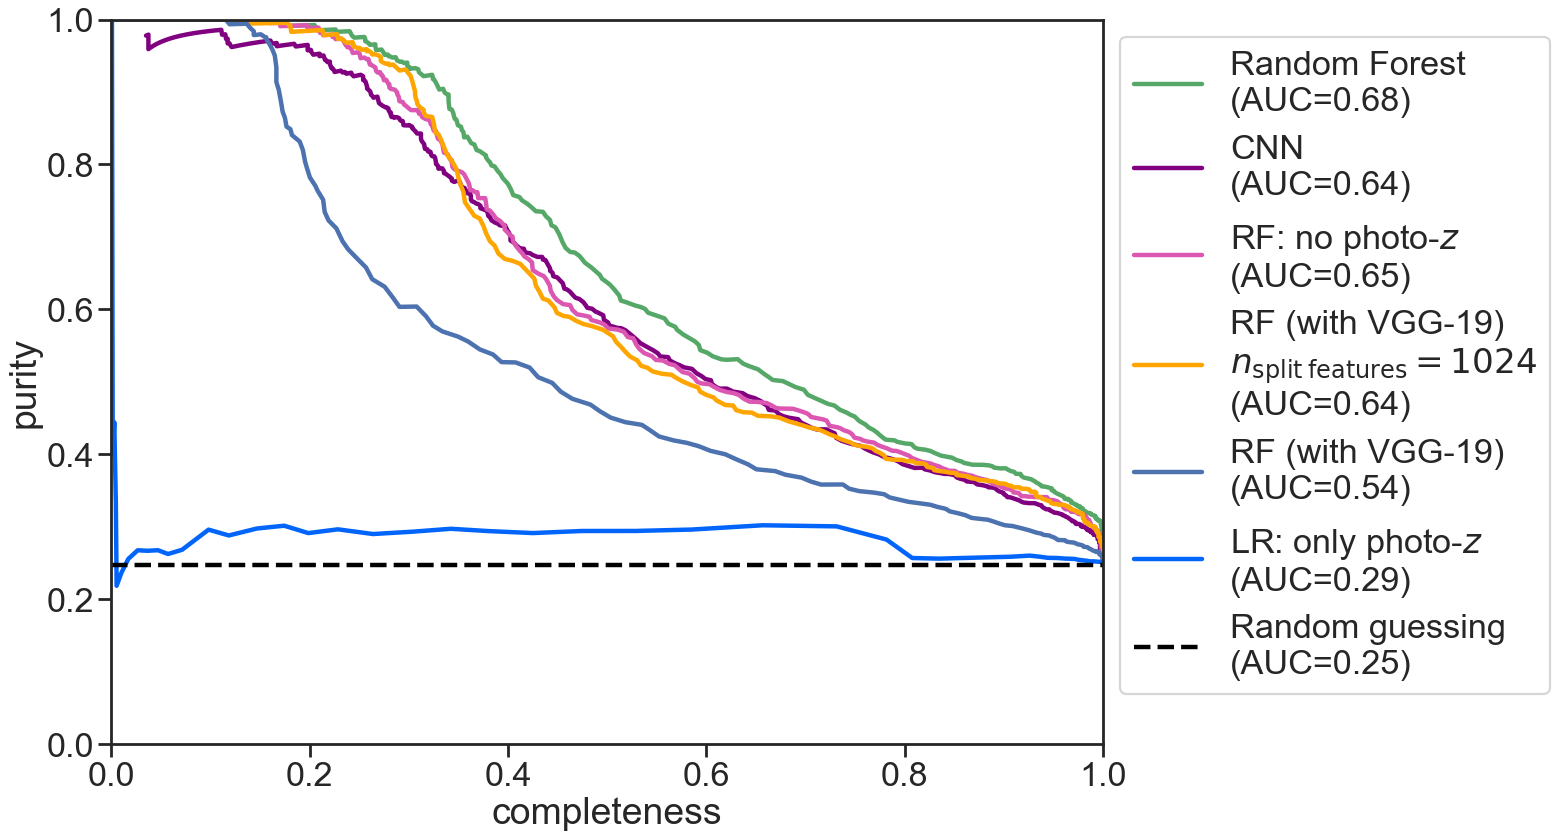

In [53]:
plot_PR_curves(
    with_RF=True, with_RF_with_vgg=True, 
    with_RF_with_vgg_more=True, 
    with_CNN=True, with_CNN_no_phot=False,
    with_RF_no_photoz=True, with_photoz=True,
)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

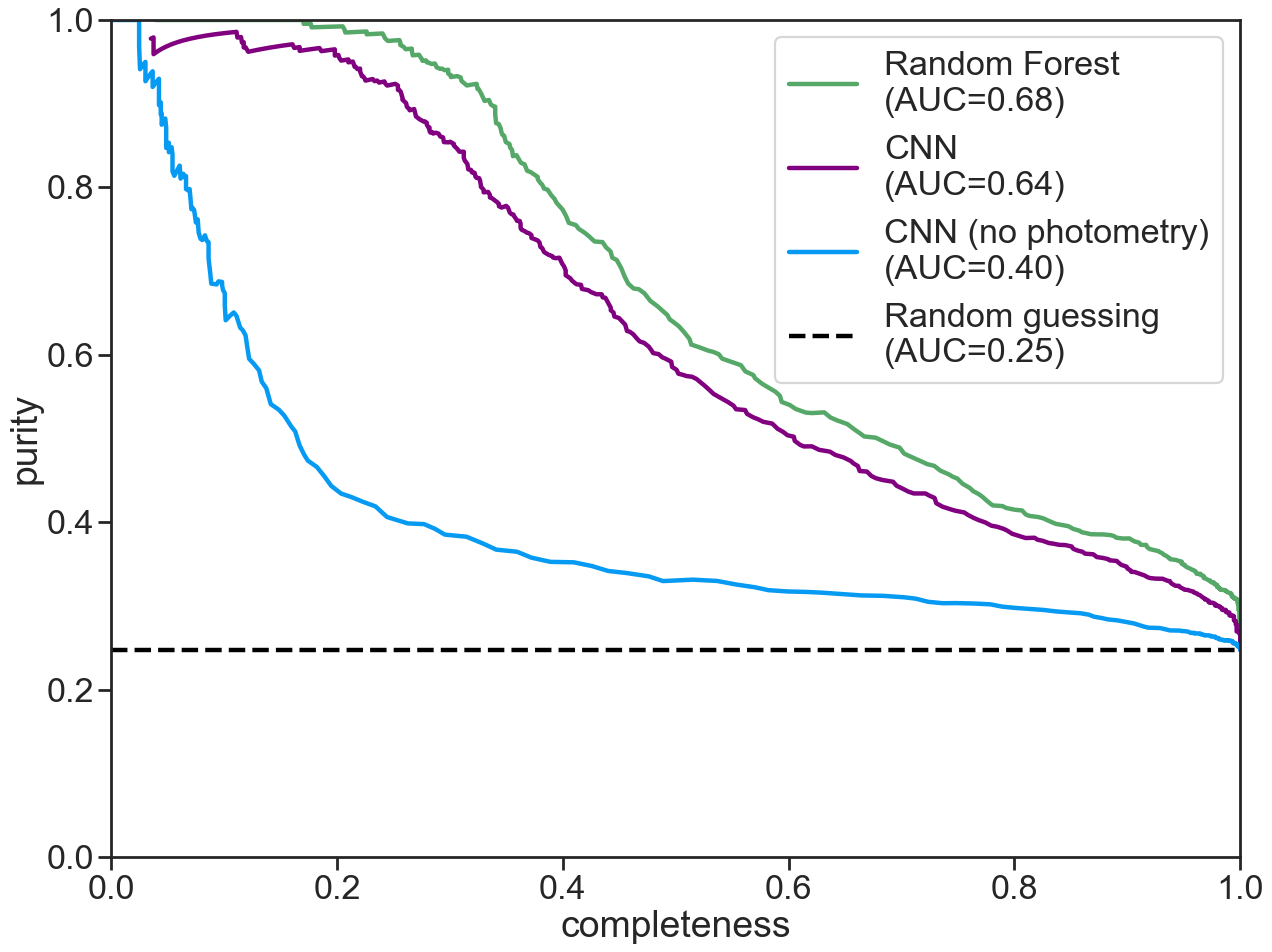

In [54]:
plot_PR_curves(with_RF=True, with_CNN=True,
               with_CNN_no_phot=True)
plt.tight_layout()

plot_filename = pathlib.Path("plots_for_thesis") / "PR-RF_CNN_CNN_nophot"
plt.savefig(plot_filename.with_suffix(".png"))
plt.savefig(plot_filename.with_suffix(".pdf"))

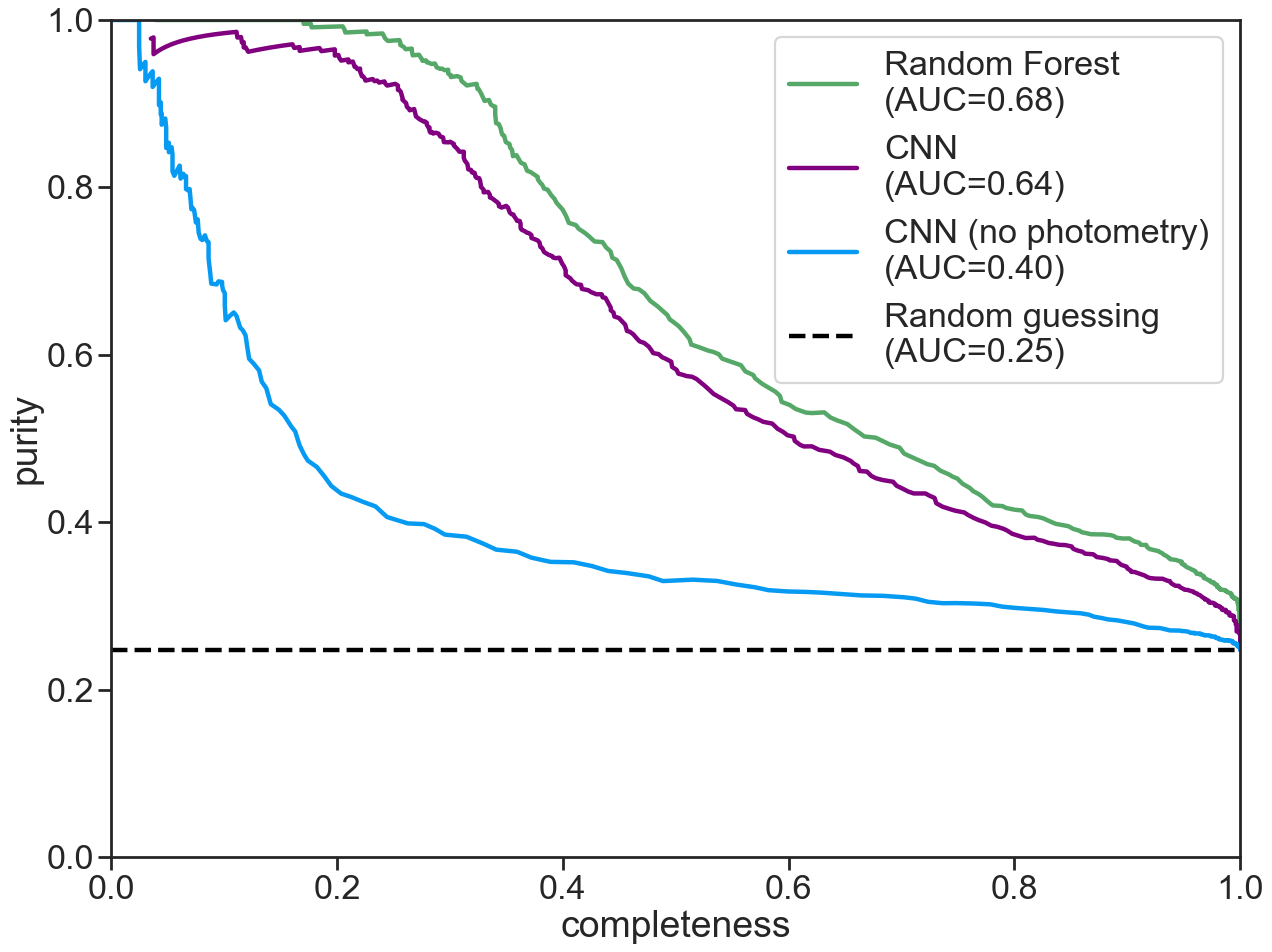

In [55]:
plot_PR_curves(with_RF=True, with_CNN=True, with_CNN_no_phot=True)
plt.tight_layout()

plot_filename = pathlib.Path("plots_for_thesis") / "PR-CNN_and_CNN_no_photometry"
plt.savefig(plot_filename.with_suffix(".png"))
plt.savefig(plot_filename.with_suffix(".pdf"))


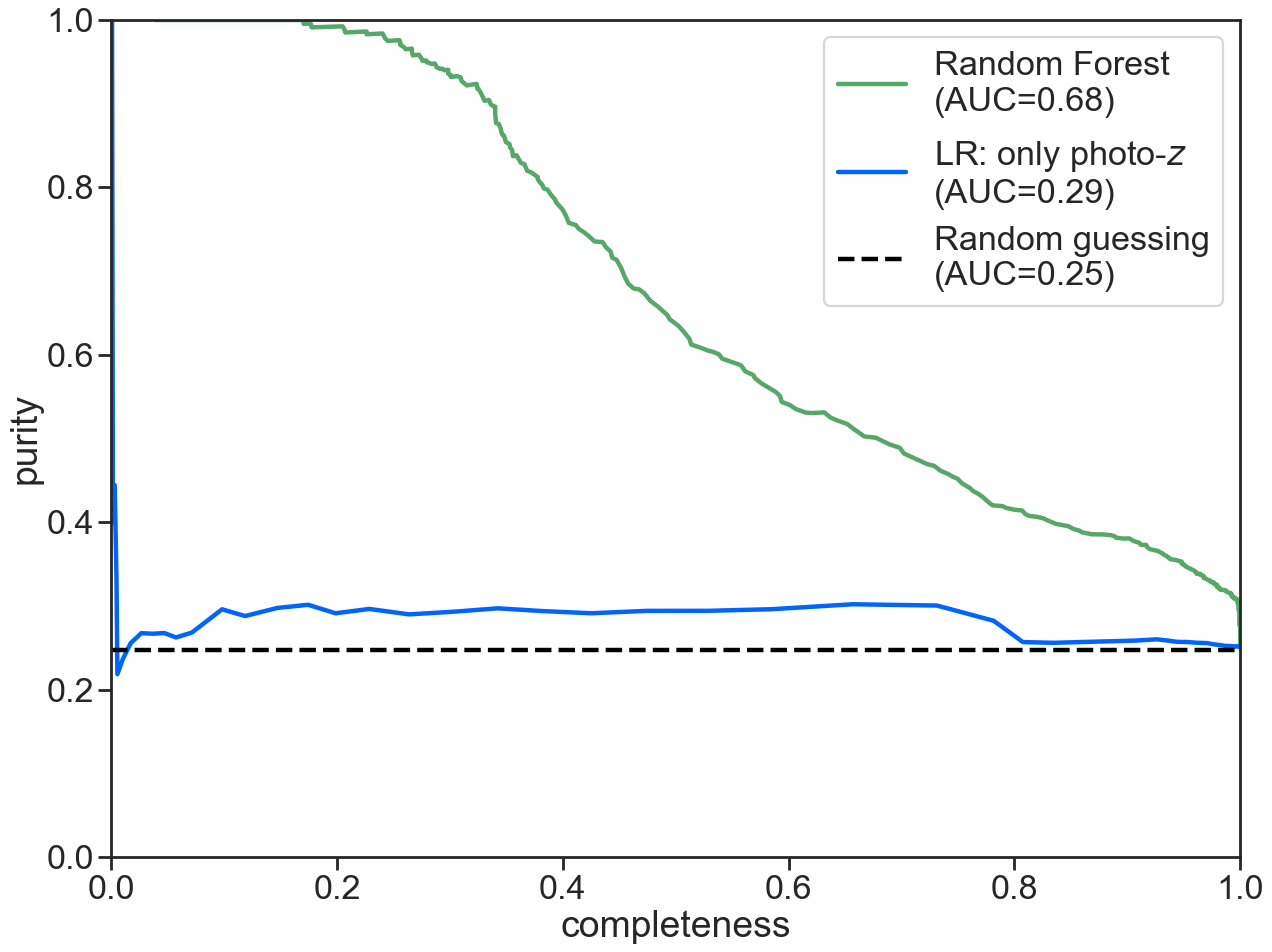

In [56]:
plot_PR_curves(with_RF=True, with_photoz=True)
plt.tight_layout()

plot_filename = pathlib.Path("plots_for_thesis") / "PR-RF_LRz"
plt.savefig(plot_filename.with_suffix(".png"))
plt.savefig(plot_filename.with_suffix(".pdf"))

# plt.legend(loc="upper left", bbox_to_anchor=(1,1))

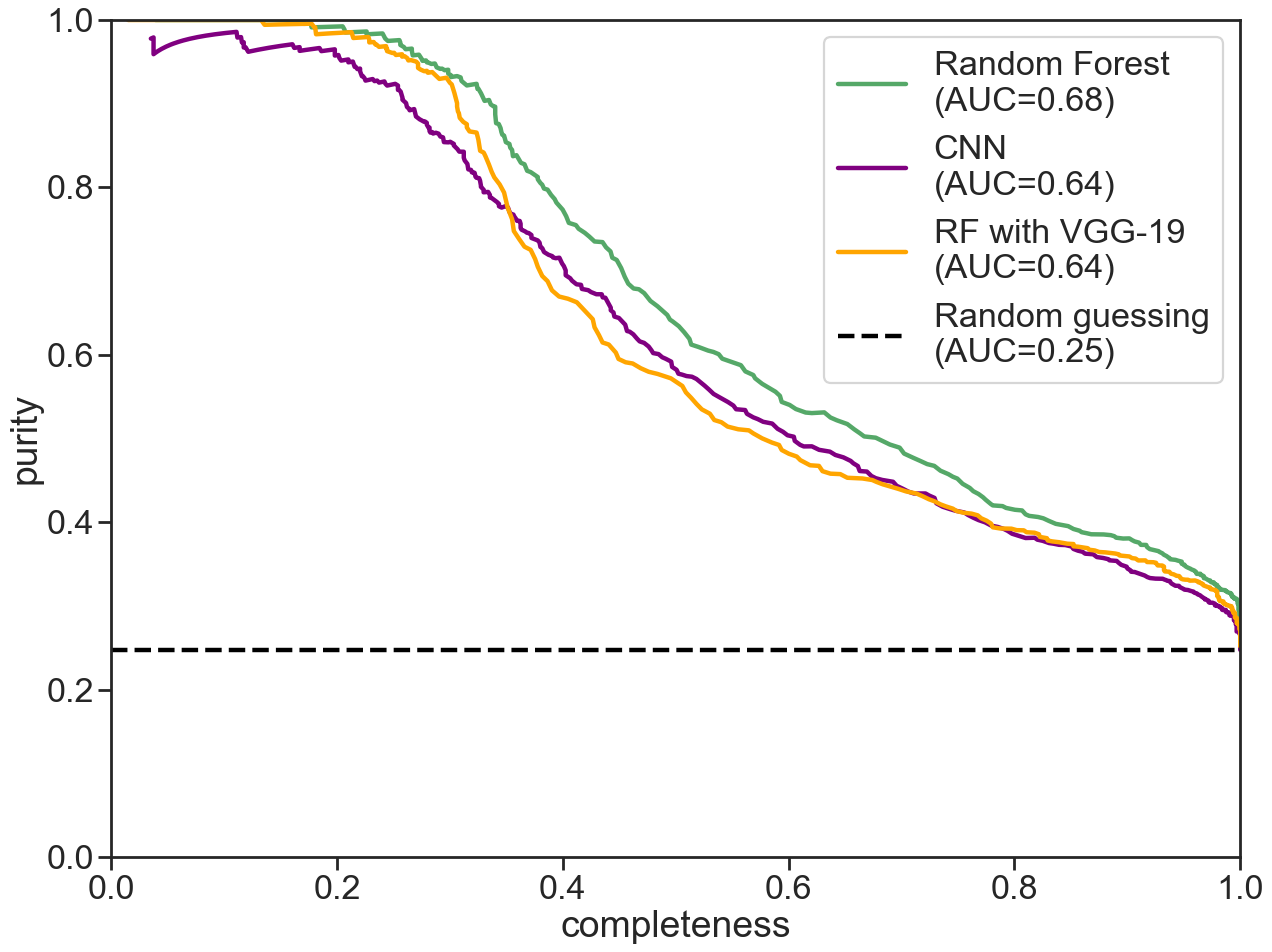

In [57]:
plot_PR_curves(with_RF=True, with_CNN=True,
               with_RF_with_vgg_more=True)
leg = plt.legend()
labels = [t.get_text() for t in leg.get_texts()]

plt.legend(
    [labels[0], 
     labels[1], 
      "RF with VGG-19\n("+ labels[2].split("(")[-1],
     labels[3],
    ],
           loc="upper right")
plt.tight_layout()

plot_filename = pathlib.Path("plots_for_thesis") / "PR-RF_RF_vgg-only_good_CNN"
plt.savefig(plot_filename.with_suffix(".png"))
plt.savefig(plot_filename.with_suffix(".pdf"))

# plt.legend(loc="upper left", bbox_to_anchor=(1,1))

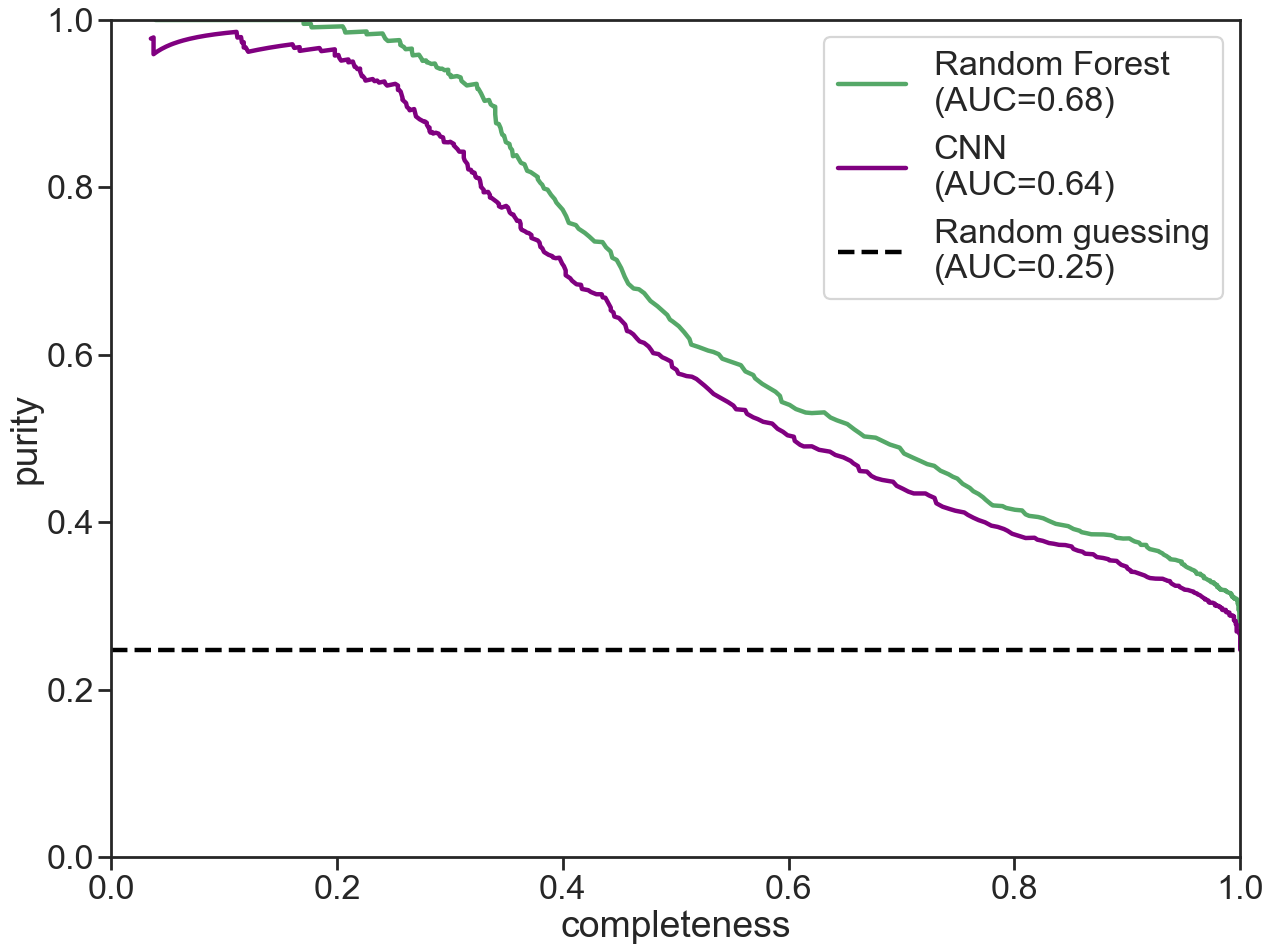

In [58]:
plot_PR_curves(with_RF=True,
               with_CNN=True,
              )
plt.tight_layout()

plot_filename = pathlib.Path("plots_for_thesis") / "PR-RF_and_CNN"
plt.savefig(plot_filename.with_suffix(".png"))
plt.savefig(plot_filename.with_suffix(".pdf"))

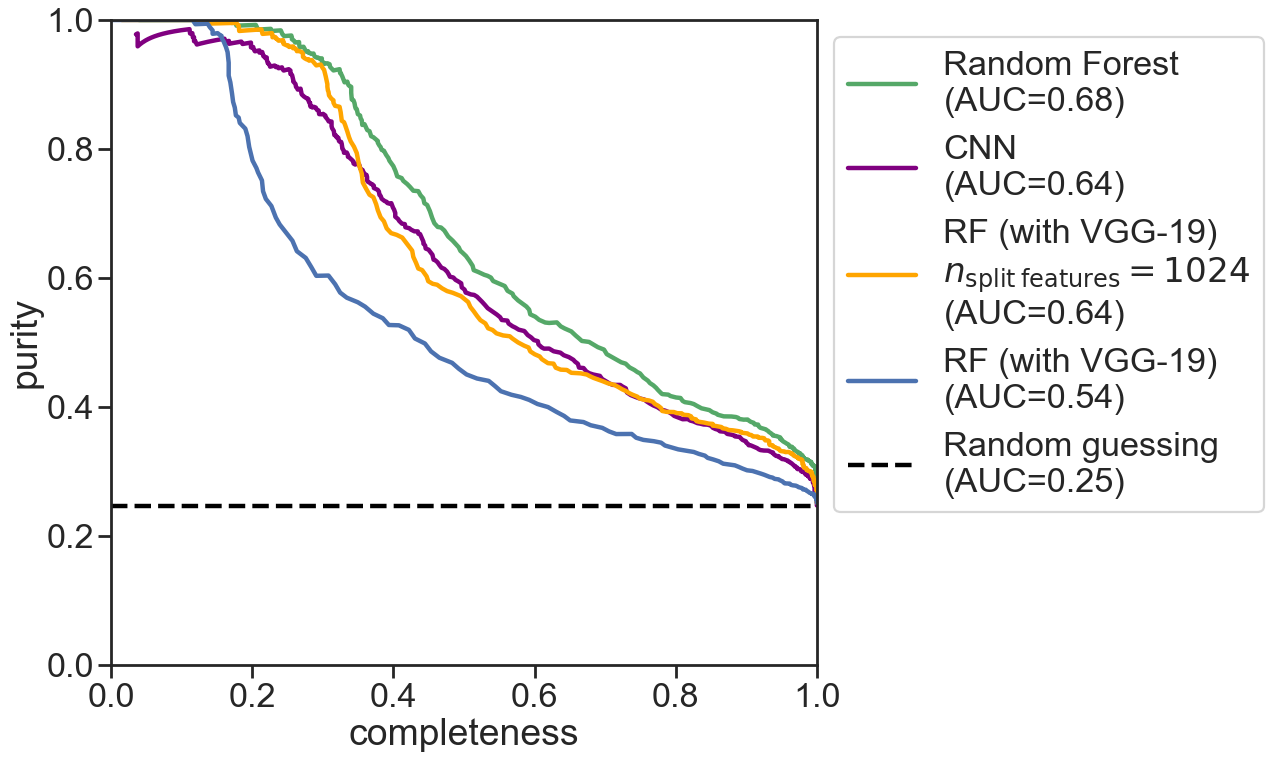

In [59]:
plot_PR_curves(
    with_RF=True,
    with_CNN=True,
    with_RF_with_vgg_more=True,
    with_RF_with_vgg=True,
)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout(rect=(0,0,1,.8))

plot_filename = pathlib.Path("plots_for_thesis") / "PR-RF_and_RFvgg"
plt.savefig(plot_filename.with_suffix(".png"))
plt.savefig(plot_filename.with_suffix(".pdf"))

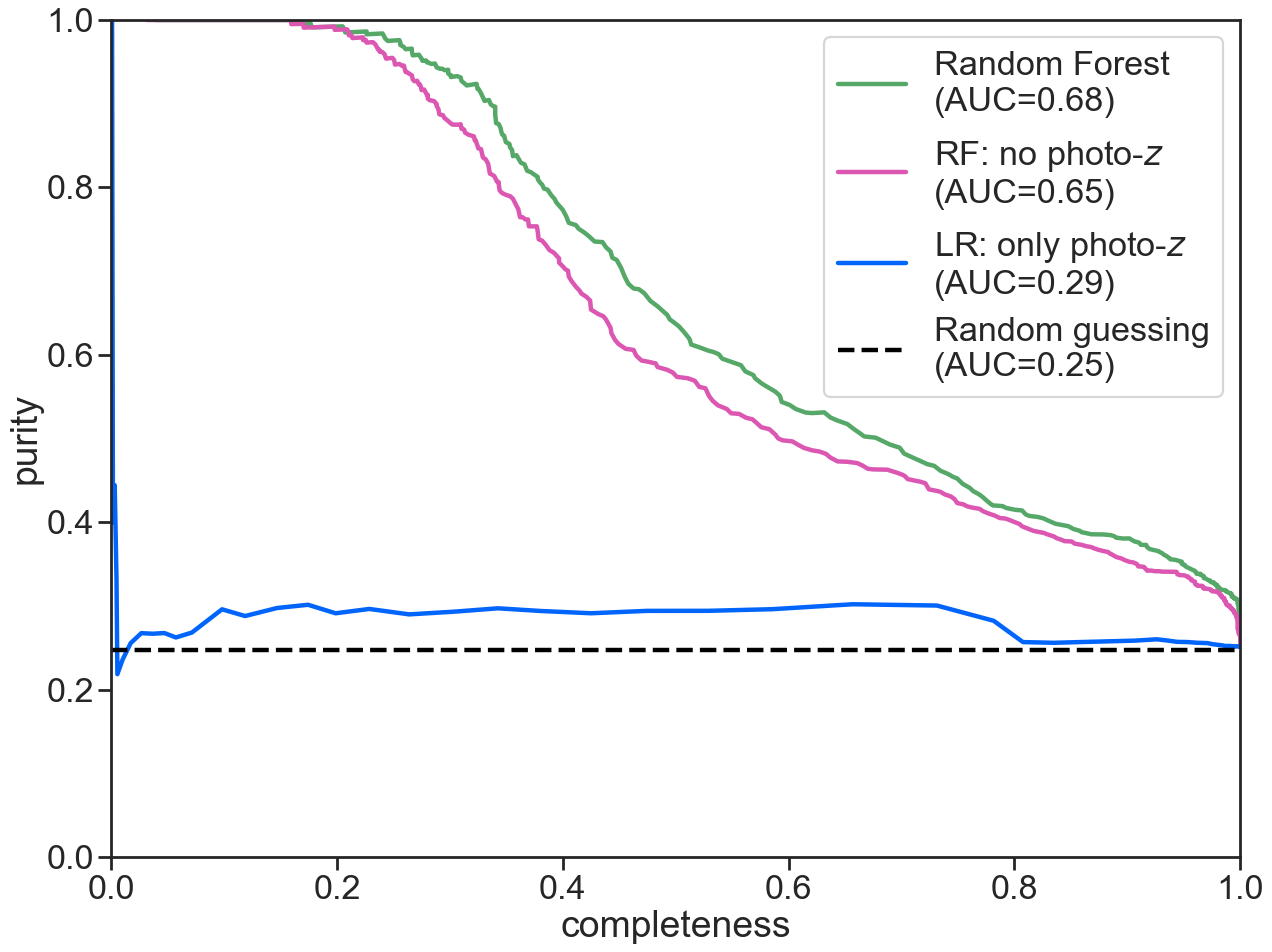

In [60]:
plot_PR_curves(
    with_RF=True,
    with_RF_no_photoz=True,
    with_photoz=True,
              )

plt.tight_layout()

plot_filename = pathlib.Path("plots_for_thesis") / "PR-RF_RFnoz_LRz"
plt.savefig(plot_filename.with_suffix(".png"))
plt.savefig(plot_filename.with_suffix(".pdf"))

# Check Probability Calibration

## Empirical (Binned) Probabilities

In [61]:
theoretical_probs=np.linspace(0,1,num=21)

In [62]:
empirical_probs_RF = np.empty(theoretical_probs.size-1)
empirical_probs_RF_with_vgg = np.empty_like(empirical_probs_RF)
empirical_probs_RF_with_vgg_more = np.empty_like(empirical_probs_RF)
empirical_probs_CNN = np.empty_like(empirical_probs_RF)
empirical_probs_CNN_no_phot = np.empty_like(empirical_probs_RF)
empirical_probs_RF_no_photoz = np.empty_like(empirical_probs_RF)
empirical_probs_photoz = np.empty_like(empirical_probs_RF)


In [63]:
for i in range(theoretical_probs.size-1):
    prob_lim_low  = theoretical_probs[i]
    prob_lim_high = theoretical_probs[i+1]
    
    mask_RF = (df_RF.prob >= prob_lim_low) & (df_RF.prob < prob_lim_high)
    empirical_probs_RF[i] = df_RF.target[mask_RF].mean()
    
    mask_RF_with_vgg = (df_RF_with_vgg.prob >= prob_lim_low) & (df_RF_with_vgg.prob < prob_lim_high)
    empirical_probs_RF_with_vgg[i] = df_RF_with_vgg.target[mask_RF_with_vgg].mean()
    
    mask_RF_with_vgg_more = (df_RF_with_vgg_more.prob >= prob_lim_low) & (df_RF_with_vgg_more.prob < prob_lim_high)
    empirical_probs_RF_with_vgg_more[i] = df_RF_with_vgg_more.target[mask_RF_with_vgg_more].mean()
    
    mask_CNN_no_phot = (df_cnn[df_cnn.testing].CNN_prob >= prob_lim_low) & (df_cnn[df_cnn.testing].CNN_prob < prob_lim_high)
    empirical_probs_CNN_no_phot[i] = df_cnn[df_cnn.testing].target[mask_CNN_no_phot].mean()
    
    mask_CNN = (df_cnn_with_photometry[df_cnn_with_photometry.testing].CNN_prob >= prob_lim_low) & (df_cnn_with_photometry[df_cnn_with_photometry.testing].CNN_prob < prob_lim_high)
    empirical_probs_CNN[i] = df_cnn[df_cnn_with_photometry.testing].target[mask_CNN].mean()
    
    mask_RF_no_photoz = (df_RF_no_photoz.prob >= prob_lim_low) & (df_RF_no_photoz.prob < prob_lim_high)
    empirical_probs_RF_no_photoz[i] = df_RF_no_photoz.target[mask_RF_no_photoz].mean()
    
    mask_photoz = (df_LR_photoz.prob >= prob_lim_low) & (df_LR_photoz.prob < prob_lim_high)
    empirical_probs_photoz[i] = df_LR_photoz.target[mask_photoz].mean()


In [64]:
def plot_probability_calibration(with_RF=False, 
                                 with_RF_with_vgg=False, 
                                 with_RF_with_vgg_more=False, 
                                 with_CNN=False,
                                 with_CNN_no_phot=False,
                                 with_RF_no_photoz=False, 
                                 with_photoz=False,
                                ):

    if with_RF:
        plt.step(theoretical_probs, [empirical_probs_RF[0], *empirical_probs_RF], 
                 linestyle="steps", color=color_RF, label=label_RF)
        
        
    if with_CNN:
        plt.step(theoretical_probs, [empirical_probs_CNN[0], *empirical_probs_CNN], 
                 linestyle="steps", color=color_CNN, label=label_CNN)
        
    if with_CNN_no_phot:
        plt.step(theoretical_probs, [empirical_probs_CNN_no_phot[0], *empirical_probs_CNN_no_phot], 
                 linestyle="steps", color=color_CNN_no_phot, label=label_CNN_no_phot)
        
        
    if with_RF_no_photoz:
        plt.step(theoretical_probs, [empirical_probs_RF_no_photoz[0], *empirical_probs_RF_no_photoz], 
                 linestyle="steps", color=color_RF_no_photoz, label=label_RF_no_photoz)
        
    if with_RF_with_vgg_more:
        plt.step(theoretical_probs, [empirical_probs_RF_with_vgg_more[0], *empirical_probs_RF_with_vgg_more], 
                 linestyle="steps", 
                 color=color_RF_with_vgg_more, 
                 label=label_RF_with_vgg_more,
                )
        
    if with_RF_with_vgg:
        plt.step(theoretical_probs, [empirical_probs_RF_with_vgg[0], *empirical_probs_RF_with_vgg], 
                 linestyle="steps", color=color_RF_with_vgg, label=label_RF_with_vgg)

        
    if with_photoz:
        plt.step(theoretical_probs, [empirical_probs_photoz[0], *empirical_probs_photoz], 
                 linestyle="steps", color=color_photoz, label=label_photoz)

    plt.fill_between(theoretical_probs, theoretical_probs-theoretical_probs[1], theoretical_probs, 
                     step="pre", color="black", label="ideal", alpha=.2,
#                      linewidth=linewidth,
                    )
    
    plt.xlabel("Reported Probability")
    plt.ylabel("Actual (Binned) Probability")

    plt.legend(loc="best")

    plt.xlim(0,1)
#     plt.ylim(0,1)


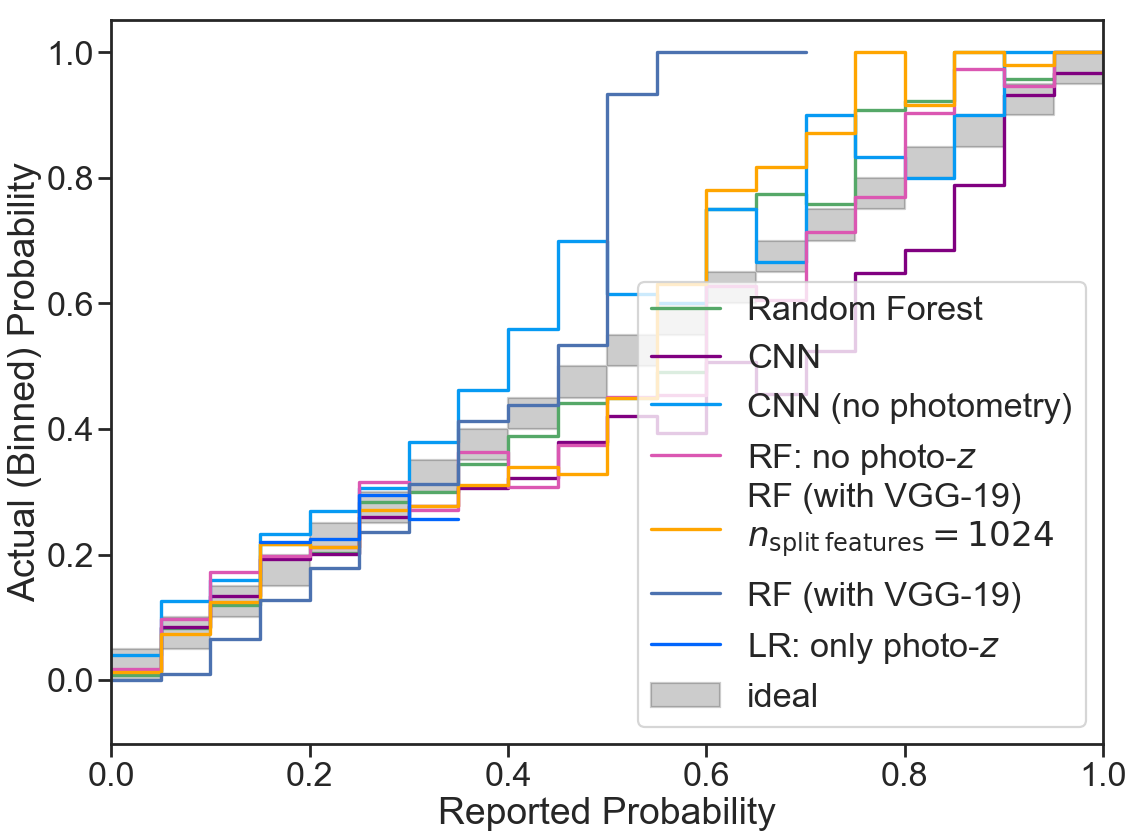

In [65]:
plot_probability_calibration(
    with_RF=True, 
    with_RF_with_vgg=True, 
    with_RF_with_vgg_more=True, 
    with_CNN=True,
    with_CNN_no_phot=True,
    with_RF_no_photoz=True, 
    with_photoz=True,
)


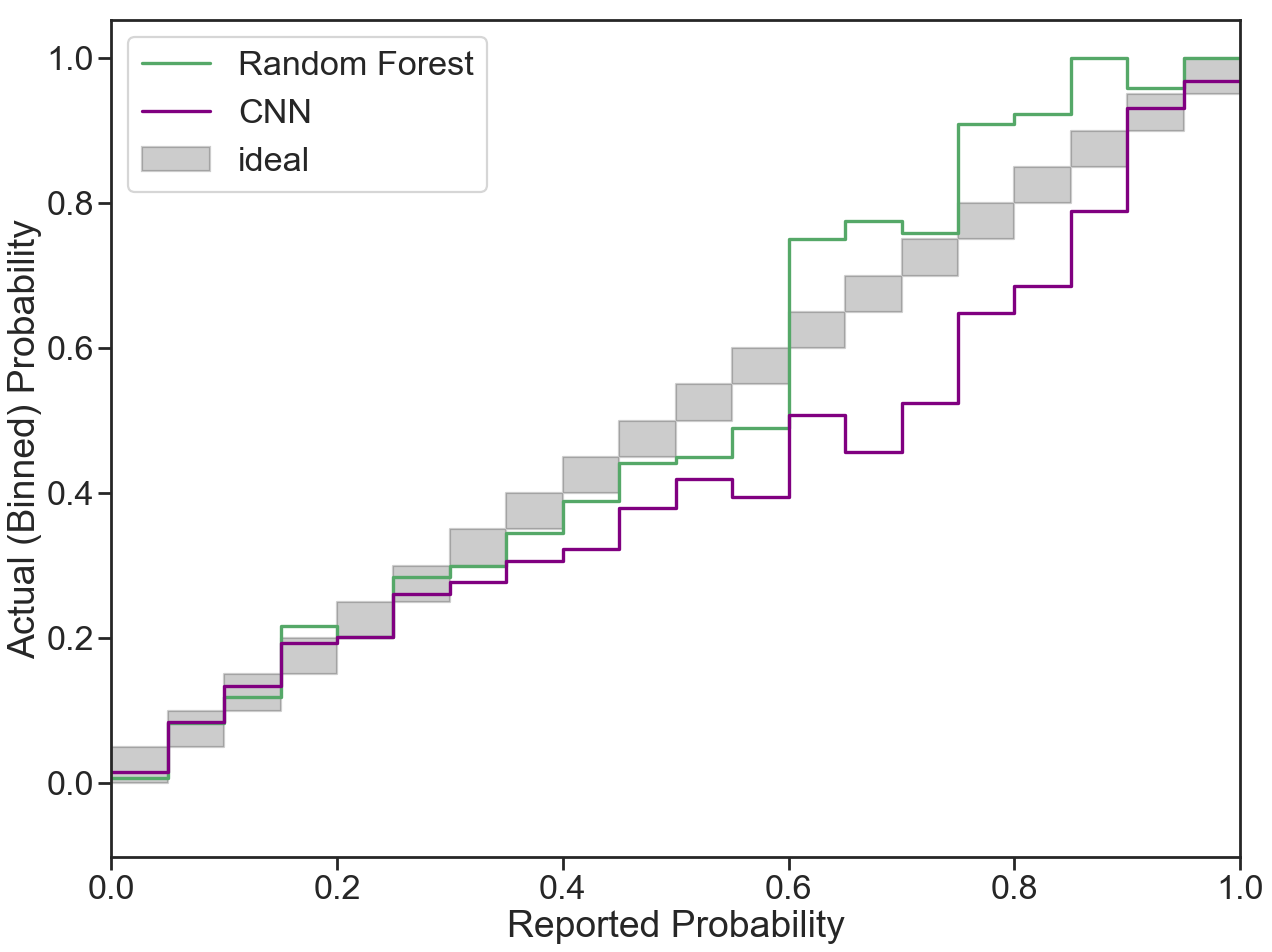

In [66]:
plot_probability_calibration(
    with_RF=True,
    with_CNN=True,
)

plt.tight_layout()

plot_filename = pathlib.Path("plots_for_thesis") / "probability_calibration-RF_and_CNN"
plt.savefig(plot_filename.with_suffix(".png"))
plt.savefig(plot_filename.with_suffix(".pdf"))

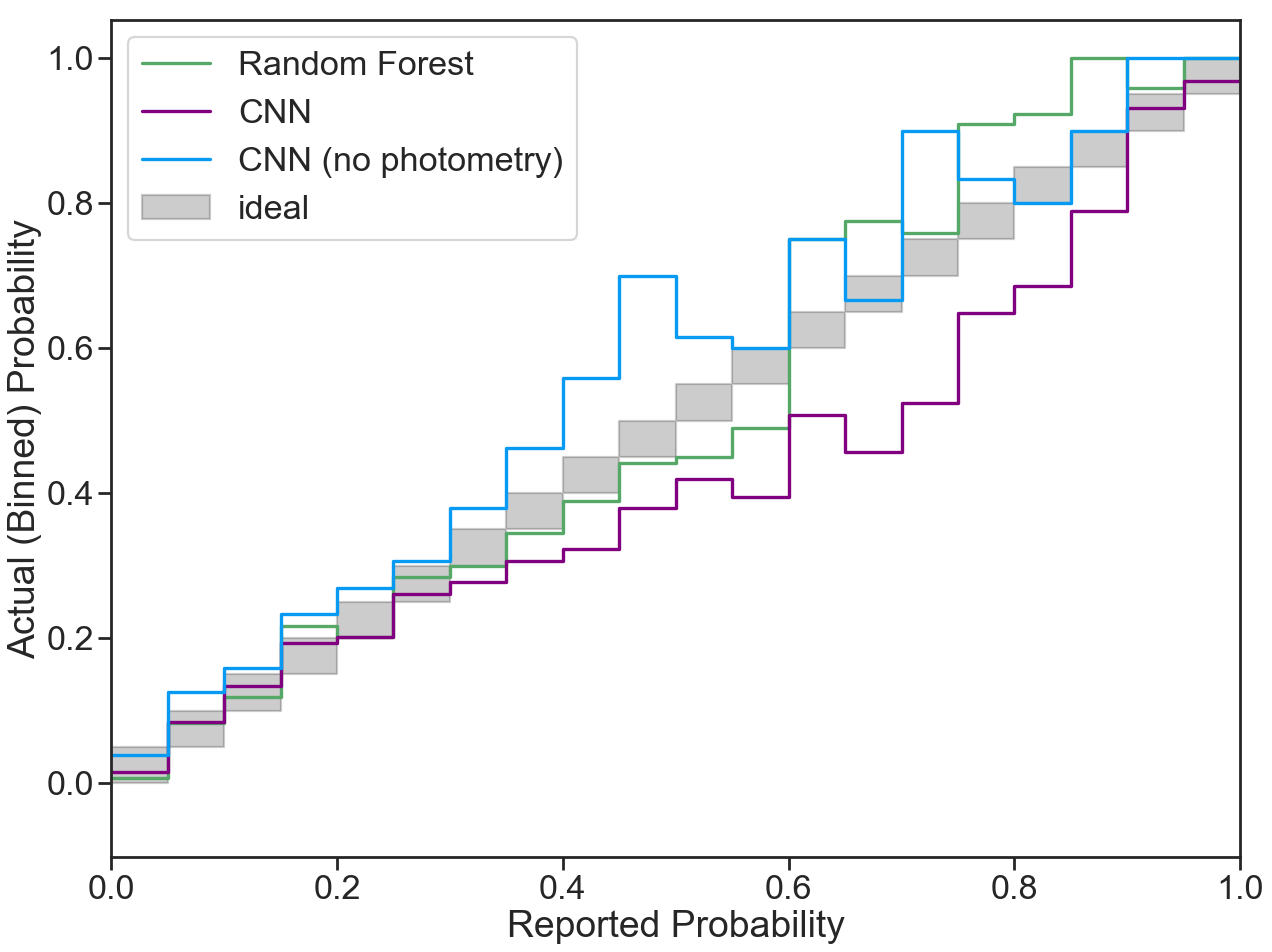

In [67]:
plot_probability_calibration(
    with_RF=True, with_CNN=True, with_CNN_no_phot=True,
)

plt.tight_layout()

plot_filename = pathlib.Path("plots_for_thesis") / "probability_calibration-CNN_and_CNN_no_photometry"
plt.savefig(plot_filename.with_suffix(".png"))
plt.savefig(plot_filename.with_suffix(".pdf"))

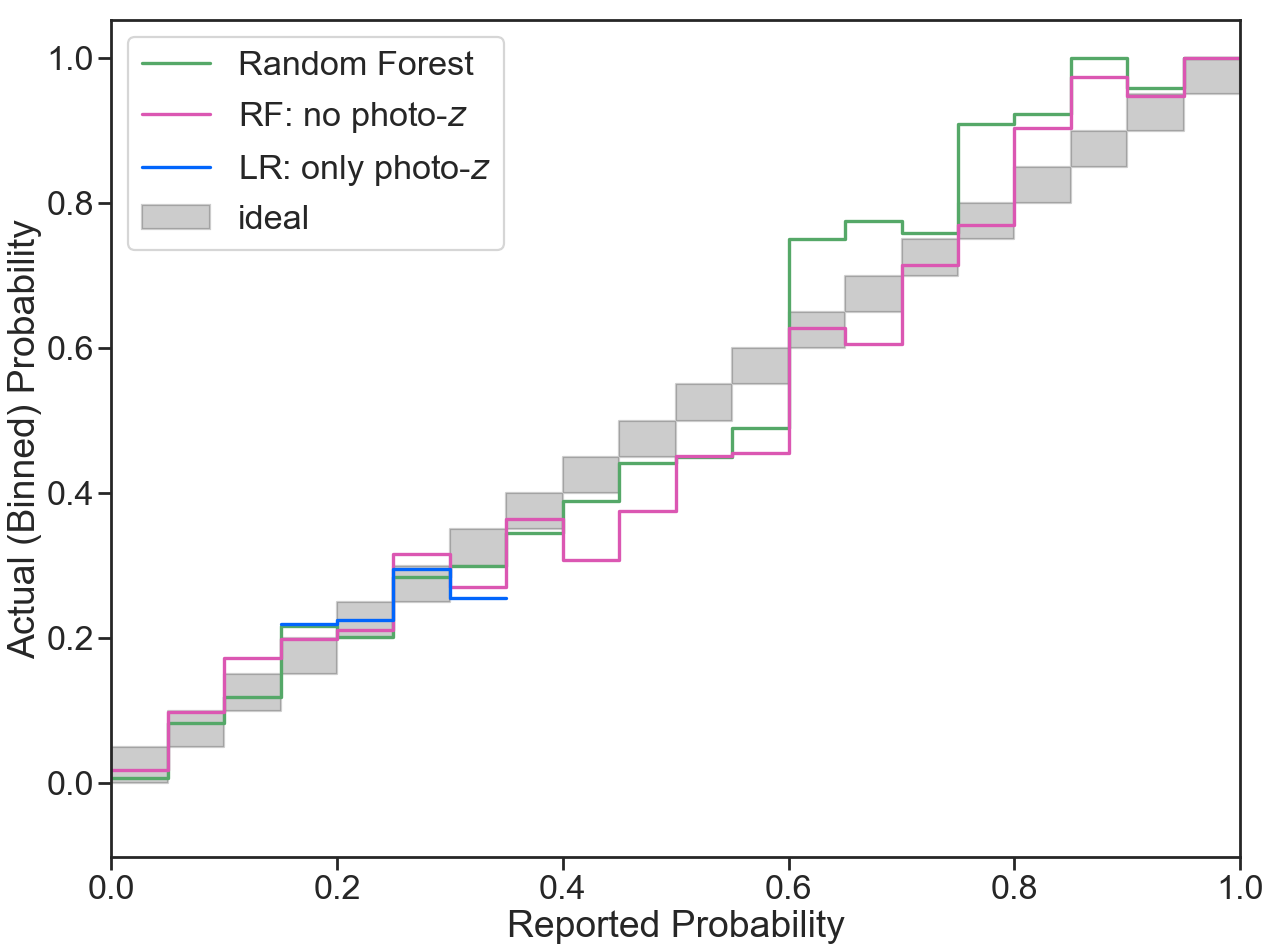

In [68]:
plot_probability_calibration(
    with_RF=True, with_RF_no_photoz=True, with_photoz=True,
)

plt.tight_layout()

plot_filename = pathlib.Path("plots_for_thesis") / "probability_calibration-RF_RFnoz_LRz"
plt.savefig(plot_filename.with_suffix(".png"))
plt.savefig(plot_filename.with_suffix(".pdf"))

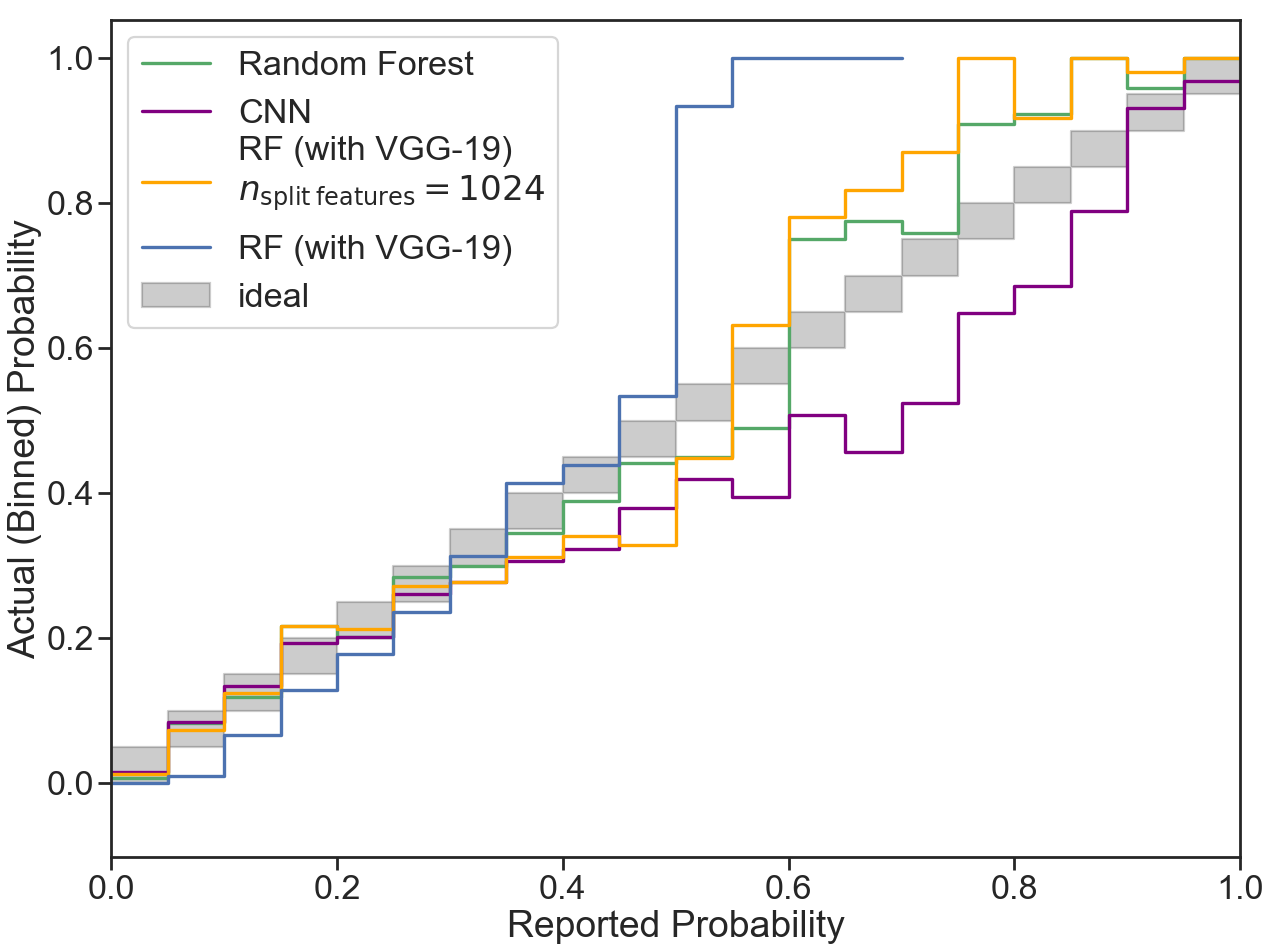

In [69]:
plot_probability_calibration(
    with_RF=True,
    with_CNN=True,
    with_RF_with_vgg_more=True,
    with_RF_with_vgg=True,
)
    
plt.tight_layout()

plot_filename = pathlib.Path("plots_for_thesis") / "probability_calibration-RF_and_RFvgg"
plt.savefig(plot_filename.with_suffix(".png"))
plt.savefig(plot_filename.with_suffix(".pdf"))

In [70]:
combined.set_index("catalog_2_ids").loc[43158176442374445]

sep                      0.279951
match                        True
error                       False
ra                        150.781
dec                       1.89451
photo_z                       0.1
log_mass                   8.4018
gcmodel_flux          2.01116e-28
gcmodel_flux_err      6.07677e-31
gcmodel_flux_flags          False
gcmodel_mag               20.6414
rcmodel_flux          2.66678e-28
rcmodel_flux_err      6.23944e-31
rcmodel_flux_flags          False
rcmodel_mag                20.335
icmodel_flux          3.11739e-28
icmodel_flux_err      1.52926e-30
icmodel_flux_flags          False
icmodel_mag               20.1655
zcmodel_flux          2.61866e-28
zcmodel_flux_err      1.34381e-30
zcmodel_flux_flags          False
zcmodel_mag               20.3548
ycmodel_flux          2.69845e-28
ycmodel_flux_err       4.5428e-30
ycmodel_flux_flags          False
ycmodel_mag               20.3222
g_minus_r                0.306355
r_minus_i                0.169506
i_minus_z     

# Measure entropy loss

In [71]:
sklearn.metrics.log_loss(df_RF.target, df_RF.prob)

0.39967049805382904

In [72]:
sklearn.metrics.log_loss(df_RF_no_photoz.target, df_RF_no_photoz.prob)

0.4223837569322251

In [73]:
sklearn.metrics.log_loss(df_LR_photoz.target, df_LR_photoz.prob)

0.561341174942831

In [74]:
sklearn.metrics.log_loss(df_RF_with_vgg.target, df_RF_with_vgg.prob)

0.5045579097981384

In [75]:
sklearn.metrics.log_loss(df_RF_with_vgg_more.target, df_RF_with_vgg_more.prob)

0.42483345932378336

In [76]:
sklearn.metrics.log_loss(df_cnn_with_photometry[df_cnn_with_photometry.testing].target,
                         df_cnn_with_photometry[df_cnn_with_photometry.testing].CNN_prob,)

0.4307537253302898

In [77]:
sklearn.metrics.log_loss(df_cnn[df_cnn.testing].target,
                         df_cnn[df_cnn.testing].CNN_prob,)

0.5327608824766119